In [2]:
## region Import Dependencies and define functions:
import warnings
warnings.filterwarnings('ignore')
import datetime

# For data processing & plotting:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as timer  # for timing code cells.
from scipy import stats
from scipy.signal import find_peaks
from scipy.stats import entropy
from scipy.signal import detrend

# For ML:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SequentialFeatureSelector  # For sequential feature sel.
from sklearn.model_selection import GridSearchCV, KFold, train_test_split  # To do parameter search
from sklearn import metrics
from sklearn.metrics import classification_report as rprt

# Classifiers for CPU based computing:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.linear_model import RidgeClassifier, LogisticRegression, Perceptron
from sklearn.metrics import confusion_matrix

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True
plt.rcdefaults()

# Only for GPU based computing: [ comment out on CPU ]
# import os  # Need both of these, run before importing cuml.

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# from cuml.svm import SVC
# from cuml.neighbors import KNeighborsClassifier
# from cuml.ensemble import RandomForestClassifier
# from sklearn.linear_model import RidgeClassifier

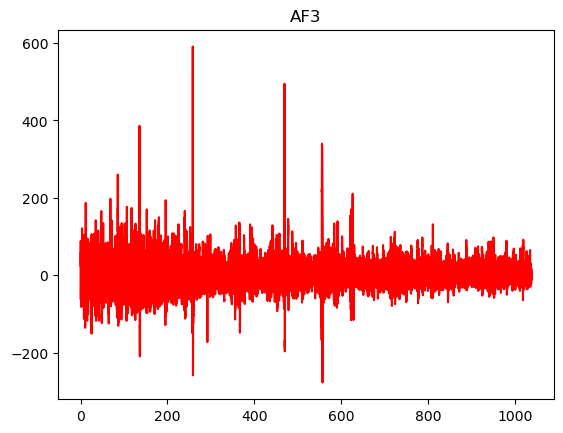

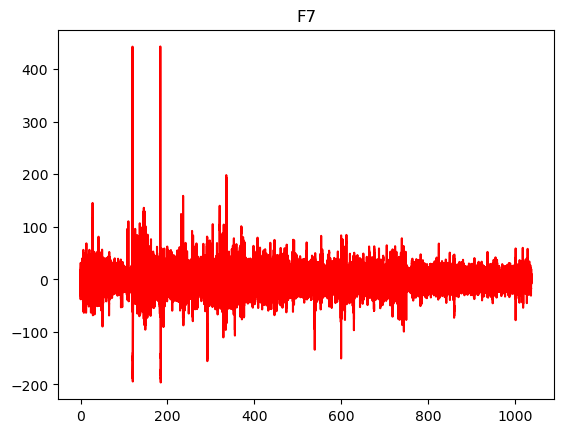

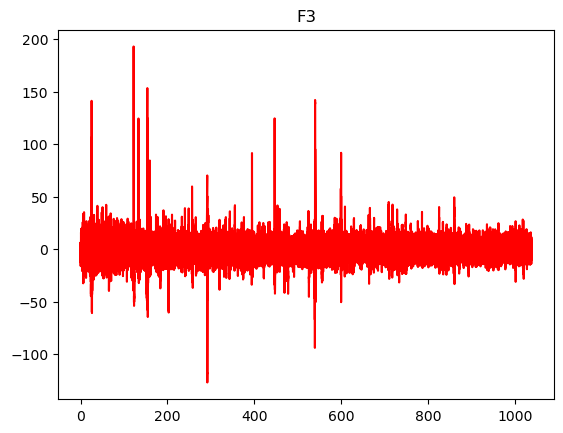

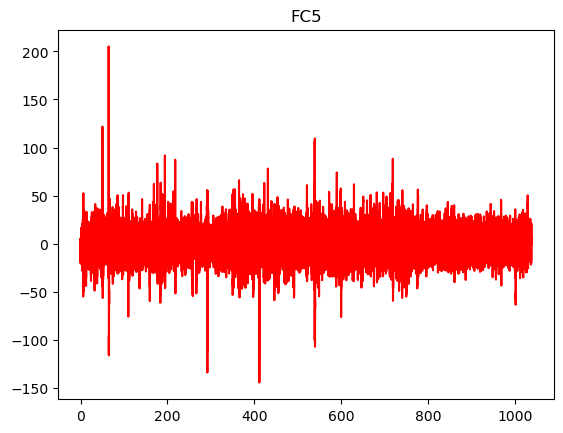

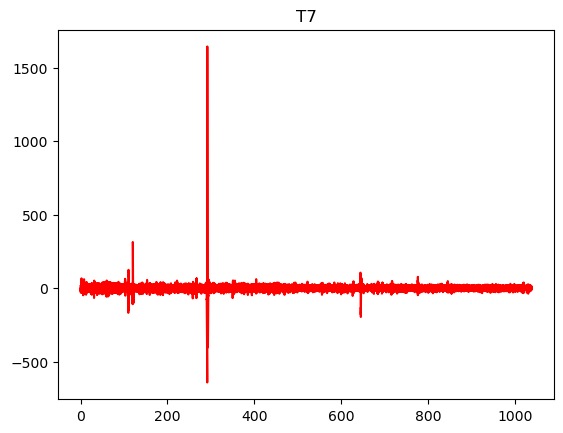

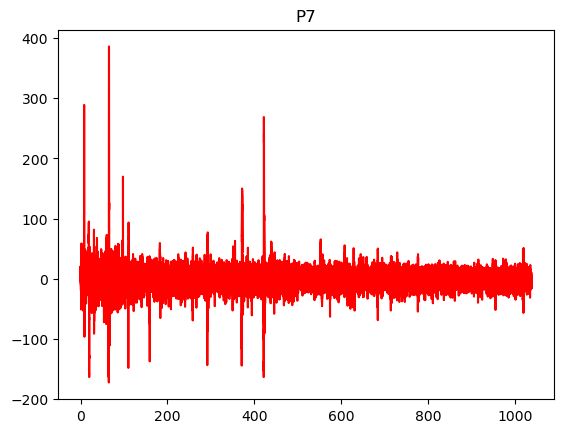

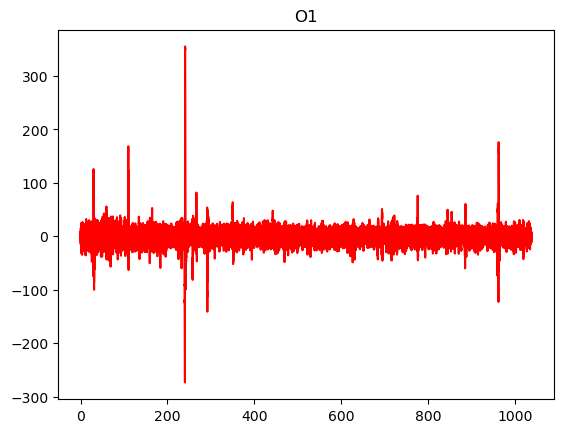

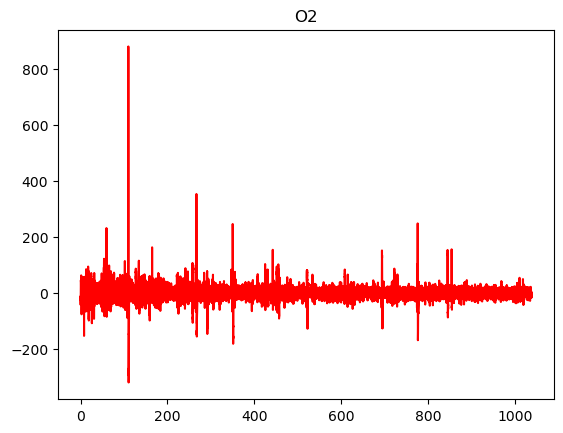

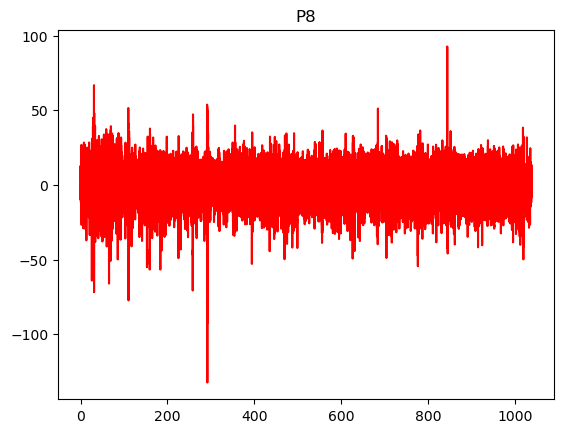

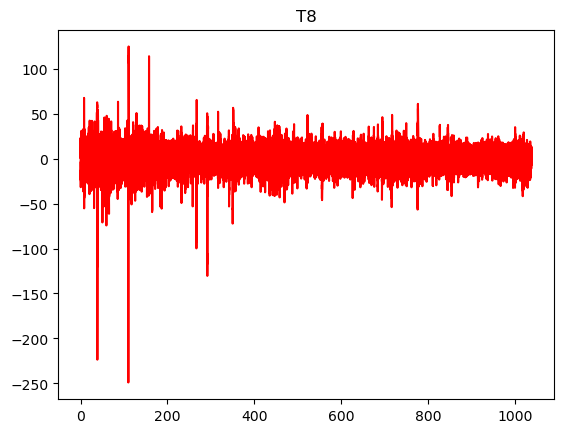

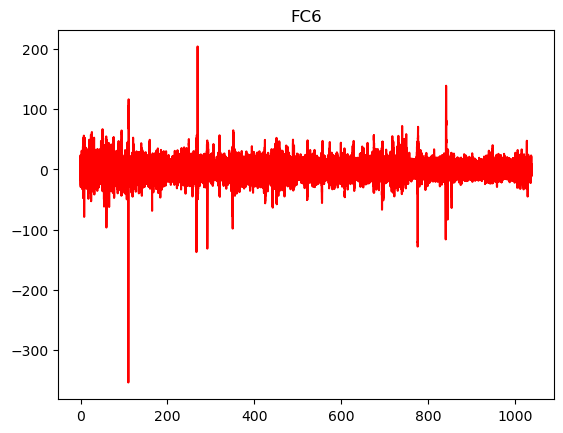

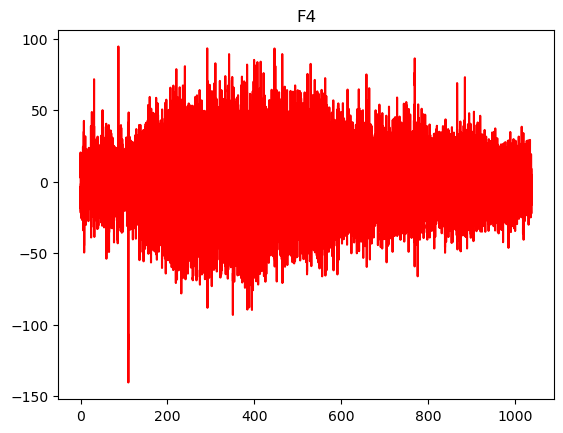

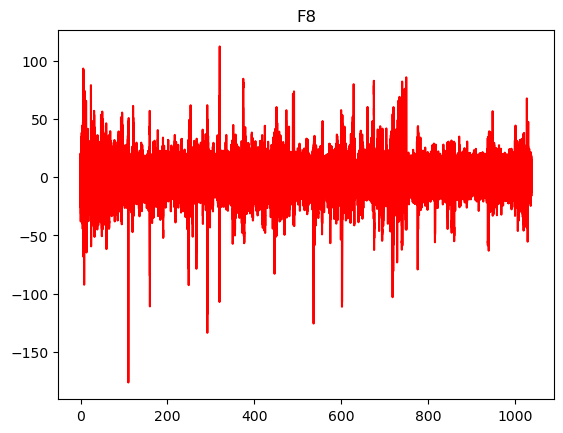

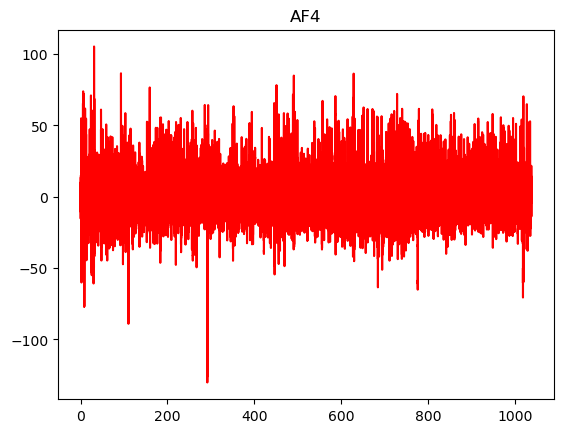

In [5]:
df=pd.read_csv('Owen_emotion.csv')
time= df.iloc[:, 0]/1000

channel_data=df.iloc[(1-1):, 1:]    
channel_data=channel_data.reset_index(drop=True)
channel_data.head()
time=time.reset_index(drop=True)
time.head()

for i in channel_data.columns:
     plt.plot(time, channel_data.loc[:,i], 'red')
     plt.title(i)
     plt.show()

In [44]:
events=pd.read_csv('Owen_eventtable.txt', delimiter=", ")
events.head()


Latency  Type  Position
0       26     0         1
1      165     1         2
2      410     0         3
3      466     0         4
4      597     0         5

In [54]:
events.loc[0]['Latency']
phase_start=events.loc[1:7:2]['Latency']
print(phase_start)
start_t=events.loc[0]['Latency']
# phase_start=[100, 200, 600]
phase_start=events.loc[1:7:2]['Latency']
# phase_end=[150, 250, 650]
phase_end=events.loc[2:8:2]['Latency']
phase_value=events.loc[1:7:2]['Type']
start_t=events.loc[0]['Latency']
print(start_t)

1    165
3    466
5    712
Name: Latency, dtype: int64
26


In [88]:
# Label Creation

df=pd.read_csv('Owen_emotion.csv')
events=pd.read_csv('Owen_eventtable.txt', delimiter=", ")
time= df.iloc[:, 0]/1000

start_t=events.loc[0]['Latency']
# phase_start=[100, 200, 600]
phase_start=events.loc[1:7:2]['Latency']
# phase_end=[150, 250, 650]
phase_end=events.loc[2:8:2]['Latency']
phase_value=events.loc[1:7:2]['Type']

time=time[time>start_t]
index_start= time.index[1]
labels=np.zeros((len(time), 1), dtype=int)
channel_data=df.iloc[(index_start-1):, 1:]    
channel_data=channel_data.reset_index(drop=True)
time=time.reset_index(drop=True)

labels=np.zeros((len(time), 1), dtype=int)
length=len(labels)
# print(length)

for j in range(3):
    index1=time[time>phase_start.iloc[j]].index[1]
    index2=time[time>phase_end.iloc[j]].index[1]
    labels[index1:index2]=phase_value.iloc[j]

channel_data['label']=labels

# eye_open_time=89.747827
# eye_close_time=217.802844
# time=time[time>89.747827]
# index_start= time.index[1]

# labels=np.zeros((len(time), 1), dtype=int)
# length=len(labels)
# print(length)
# for i in range(length):
#      if time[i]> eye_close_time:
#         labels[i]=1


129554
129554
129554


0

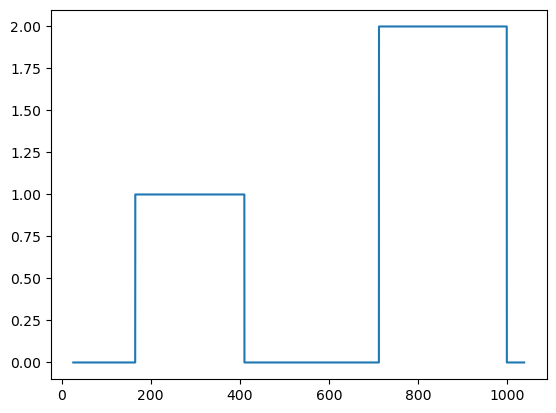

In [89]:
print(len(labels))
print(len(time))
plt.plot(time,labels)
type(labels)
print(len(channel_data))
channel_data.head()
time.index[0]

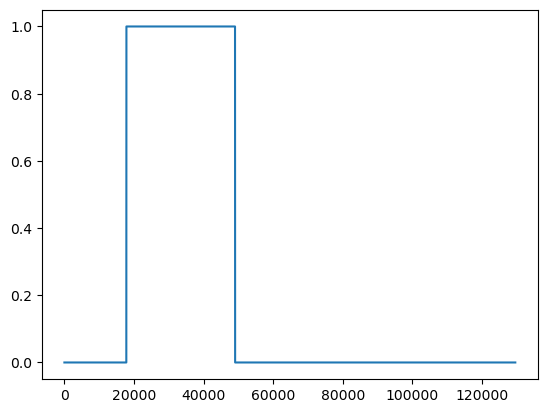

In [3]:
def get_data(File_name, Event_file_name):  # Filename is a string in colons. event 1 is start of eye open, event2 is start of eye close
    df=pd.read_csv(File_name)
    events=pd.read_csv(Event_file_name)
    
    time= df.iloc[:, 0]/1000
    start_t=events.loc[0]['Latency']
    phase_start=events.loc[1:7:2]['Latency']
    phase_end=events.loc[2:8:2]['Latency']
    phase_value=events.loc[1:7:2]['Type']
    time=time[time>start_t]
    index_start= time.index[1]  # randomly removing initial artifact
    channel_data=df.iloc[(index_start)-1:, 1:]  
   
    channel_data=channel_data.reset_index(drop=True)
    time=time.reset_index(drop=True)
    
    labels=np.zeros((len(time), 1), dtype=int)
    
    
    
  
    for j in range(3):
        index1=time[time>phase_start.iloc[j]].index[1]
        index2=time[time>phase_end.iloc[j]].index[1]
        labels[index1:index2]=phase_value.iloc[j]

    channel_data['label']=labels

#     title_name=File_name.replace('.csv',"")
#     fig, axs = plt.subplots(nrows=15, ncols=1, figsize=(6,10))
#     fig.suptitle(title_name)
#     for i in range(len(channel_data.columns)):
#         axs[i].plot(time, channel_data.iloc[:,i], 'red')
#         axs[i].set_ylabel(f'{channel_data.columns[i]}')
        
#     plt.show()
    return channel_data, time, labels


p1_df,p1_t, p1_label_value=get_data('Owen_emotion.csv','owen_events.csv ')
modifier_pos=p1_df[p1_df.loc[:,'label']<2].loc[:,'label']
plt.plot(modifier_pos)

# modifier_neg=p1_df['label'==2].loc[:,'label']
# def merge_data(data_to_be_merged, column_names):   

#     merged_data = pd.DataFrame(columns=column_names)
   
#     # merged_df = pd.concat([p1_df, p1_df], axis=0)
#     # merged_df.columns
#     # # plt.plot(merged_df.loc[:,'label'])
#     # merged_df.loc[:,'label']
    
    
#     for i in range(len(data_to_be_merged)):
#         data_temp =data_to_be_merged[i]
#         merged_data = pd.concat([merged_data, data_temp])

#     #  Reset index
#     merged_data.reset_index(drop=True, inplace=True)
#     plt.plot( merged_data.loc[:,'label'])
#     return  merged_data


In [4]:
def merge_data(data_to_be_merged, column_names):   

    merged_data = pd.DataFrame(columns=column_names)
   
    # merged_df = pd.concat([p1_df, p1_df], axis=0)
    # merged_df.columns
    # # plt.plot(merged_df.loc[:,'label'])
    # merged_df.loc[:,'label']
    
    
    for i in range(len(data_to_be_merged)):
        data_temp =data_to_be_merged[i]
        merged_data = pd.concat([merged_data, data_temp])

    #  Reset index
    merged_data.reset_index(drop=True, inplace=True)
    plt.plot( merged_data.loc[:,'label'])
    return  merged_data

In [5]:
def plot_data(merged_data):
    fig, axs = plt.subplots(nrows=15, ncols=1, figsize=(6, 10))
    fig.suptitle("Plot of all data channels")
    modifier_pos=merged_data[merged_data.loc[:,'label']<2].loc[:,'label']
    modifier_neg=merged_data[merged_data.loc[:,'label']>1].loc[:,'label']
    
    
    for i in range(np.shape(merged_data)[1]):
        p1=axs[i].plot(merged_data.iloc[:, i], 'blue', label='Neutral')
        x=merged_data.iloc[:,i]*modifier_pos
        y=merged_data.iloc[:,i]*modifier_neg
        p2=axs[i].plot(x, 'red',label='Positive')
        p3=axs[i].plot(y, 'green', label='Negative')
        axs[i].set_title(merged_data.columns[i])
        
    fig.legend(handles=[p1,p2,p3], labels=['Neutral', 'Positive', 'Negative'])
    
    return 
    

111595

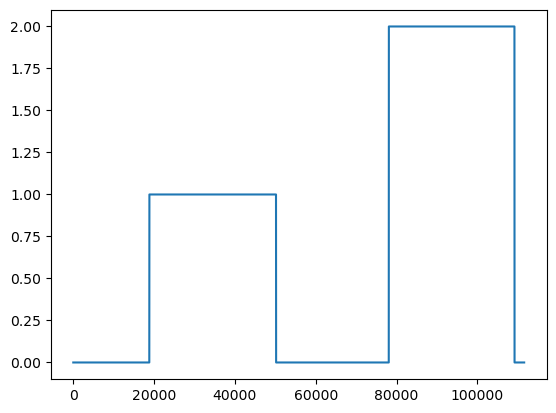

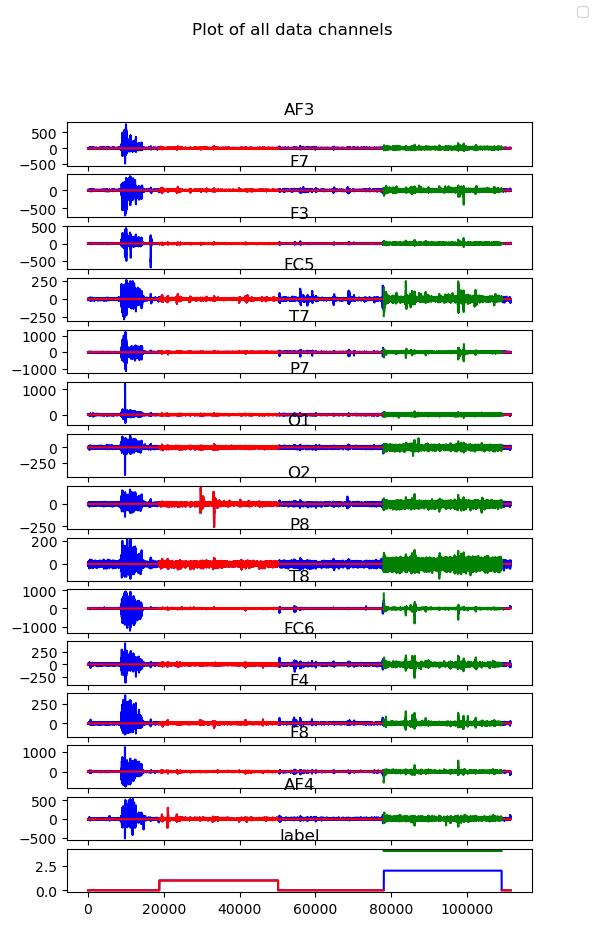

In [13]:
# p1_df,p1_t, p1_label_value=get_data('Owen_emotion.csv','owen_events.csv ')
# p2_df,p2_t, p2_label_value=get_data('Munia_emotion.csv','munia_events.csv ')
p3_df,p3_t, p3_label_value=get_data('onyx_emotion.csv','onyx_events.csv ')
# p4_df,p4_t, p4_label_value=get_data('Samiha_emotion.csv','samiha_events.csv ')
# p5_df,p5_t, p5_label_value=get_data('Terrance_emotion.csv','terrance_events.csv ')

# list_of_data=[p1_df,p2_df,p3_df,p4_df,p5_df]

list_of_data=[p3_df]
merged_data=merge_data(list_of_data, p1_df.columns)
plot_data(merged_data)
merged_data.loc[:,'label']
merged_data.columns
len(merged_data)

# p1_df.loc[:,'label']




In [19]:
len(merged_data)


111595

In [16]:
# Define function to partition into windows and calculate window-wise metrics, using dataframe
def window_partition(data, window_size, overlap, column_names,  balanced=True):

    step_size = window_size - overlap
    new_data=pd.DataFrame(columns=column_names)
    label_list=[]
    for i in column_names:
        x=[]
        for j in range(0, len(data), step_size): 
            xs= data[i].values[j:j + window_size]
            x.append(xs)      
        new_data[i]=pd.DataFrame({i:x})
        new_data.reset_index(drop=True, inplace=True)
#     
    for j in range(0, len(data), step_size): 
            lab = stats.mode(data['label'].values[j:j + window_size])[0][0]
            label_list.append(lab)
    
#     plt.plot(label_list,'o')
#     plt.show()
    X = pd.DataFrame()

    for i in new_data.columns:   
        new_data_fft = new_data[i].apply(lambda x: np.abs(np.fft.fft(x))[0:])
        freq = new_data[i].apply(lambda x: np.abs(np.fft.fftfreq(window_size, d=1/128)))
        X[f'mean_fft{i}'] = new_data_fft.apply(lambda x: np.mean(x))
        # Max Freq Index
        X[f'max_freq_idx{i}'] = new_data_fft.apply(lambda x: np.argmax(x))
        # Min Freq Index [Ignore first entry since close to zero]
        X[f'min_freq_idx{i}'] = new_data_fft.apply(lambda x: np.argmin(x))
        # Entropy
        X[f'entr_fft{i}'] =new_data_fft.apply(lambda x: entropy(x))
        # std dev
        X[f'std_fft{i}'] = new_data_fft.apply(lambda x: x.std())
        # min [ignore zeros]
        X[f'min_fft{i}'] = new_data_fft.apply(lambda x: np.min(x[np.nonzero(x)]))
        # max
        X[f'max_fft{i}'] = new_data_fft.apply(lambda x: x.max())
        # median
        X[f'median_fft{i}'] = new_data_fft.apply(lambda x: np.median(x))
        # number of peaks
        X[f'peak_count_fft{i}'] = new_data_fft.apply(lambda x: len(find_peaks(x)[0]))
        # skewness
        X[f'skewness_fft{i}'] = new_data_fft.apply(lambda x: stats.skew(x))
        # kurtosis
        X[f'kurtosis_fft{i}'] = new_data_fft.apply(lambda x: stats.kurtosis(x))
        # energy
        X[f'energy_fft{i}'] = new_data_fft.apply(lambda x: np.sum(x ** 2) / 100)
    
#     for j in range(len(new_data_fft)):
#         plt.plot(freq[j], new_data_fft[j])   
#         plt.show()
    return  X, label_list
            

features, label_list=window_partition(merged_data, window_size=1280, overlap=0, column_names=['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6',
       'F4', 'F8', 'AF4'])



In [17]:
len(features)
cols=features.columns
print(cols)


Index(['mean_fftAF3', 'max_freq_idxAF3', 'min_freq_idxAF3', 'entr_fftAF3',
       'std_fftAF3', 'min_fftAF3', 'max_fftAF3', 'median_fftAF3',
       'peak_count_fftAF3', 'skewness_fftAF3',
       ...
       'min_freq_idxAF4', 'entr_fftAF4', 'std_fftAF4', 'min_fftAF4',
       'max_fftAF4', 'median_fftAF4', 'peak_count_fftAF4', 'skewness_fftAF4',
       'kurtosis_fftAF4', 'energy_fftAF4'],
      dtype='object', length=168)


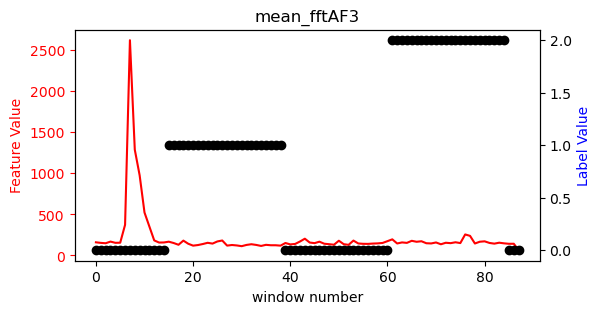

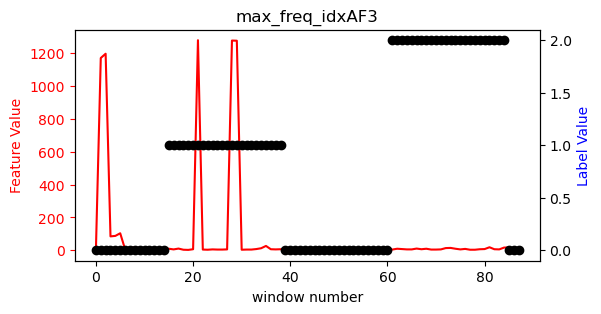

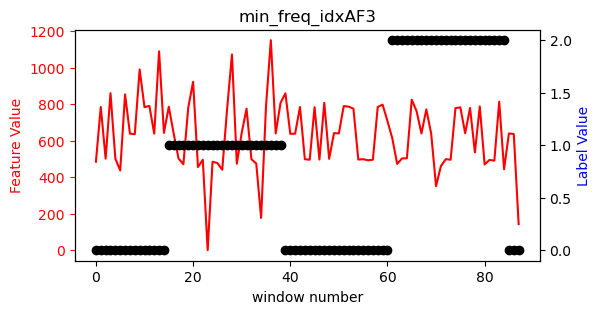

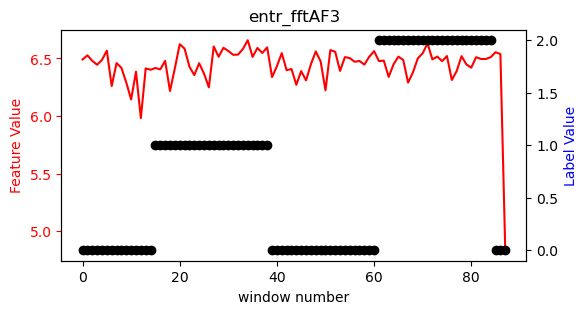

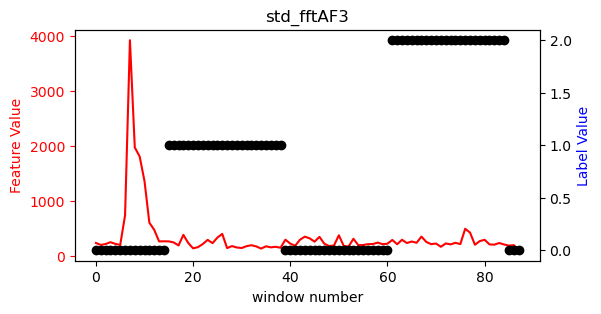

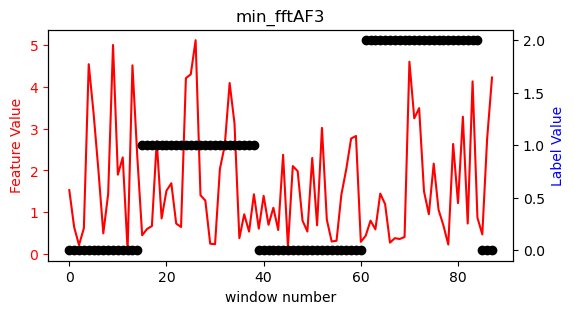

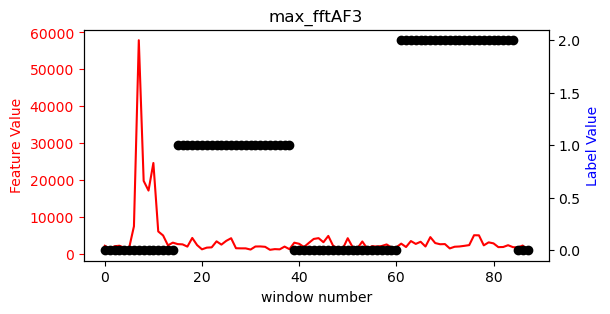

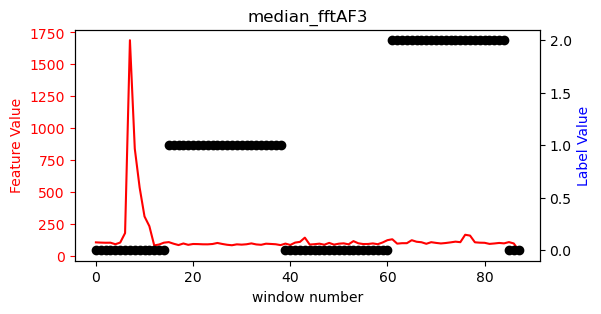

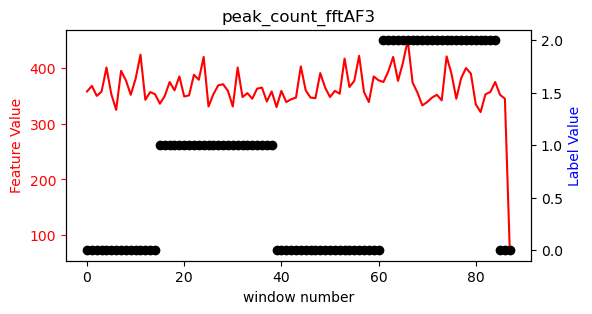

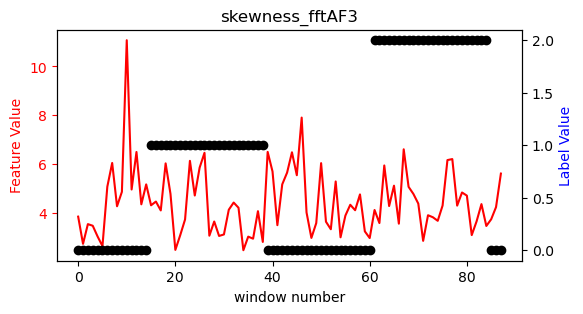

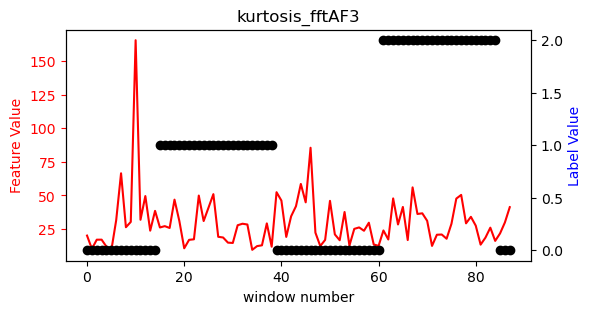

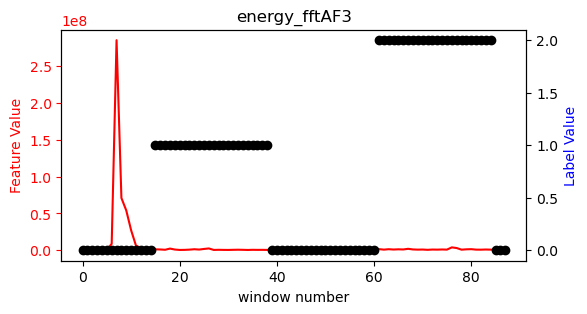

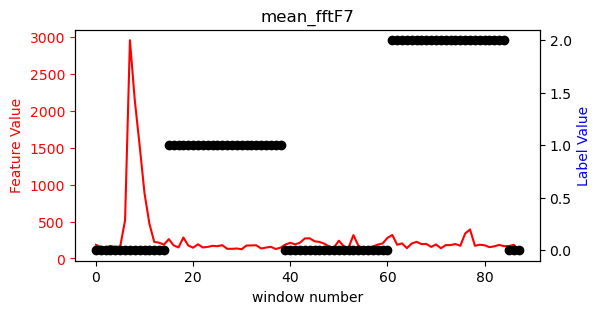

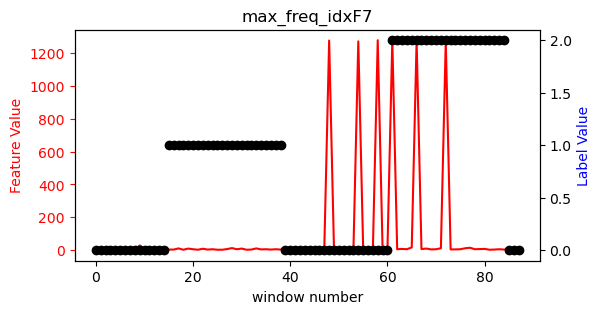

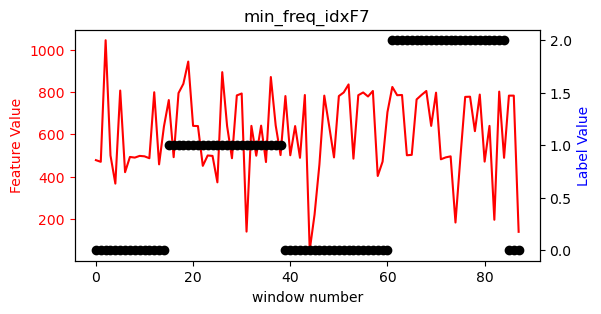

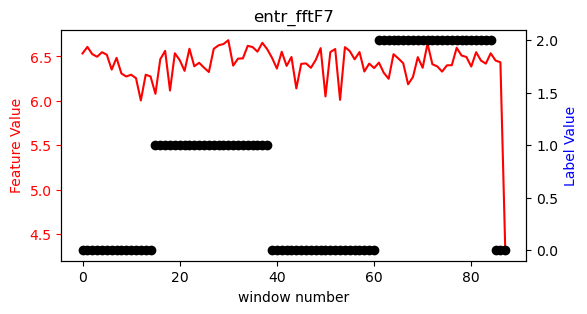

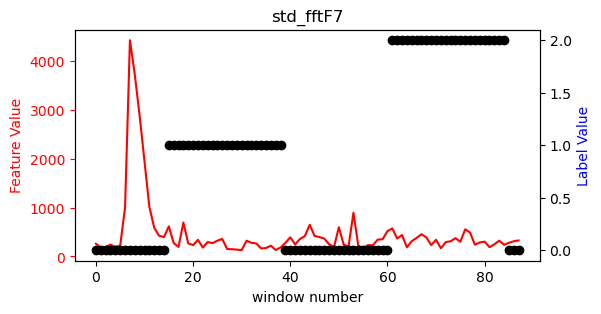

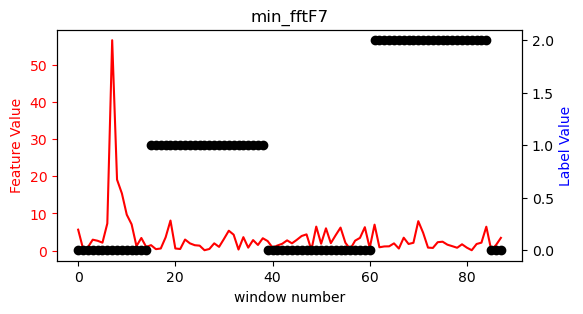

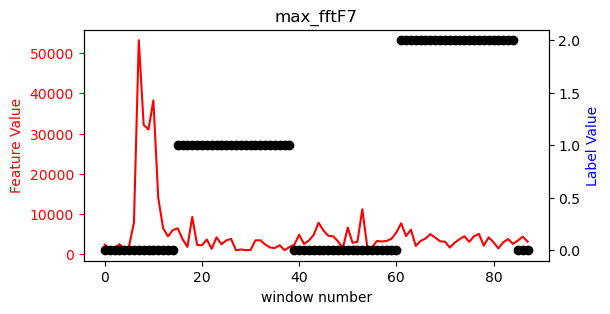

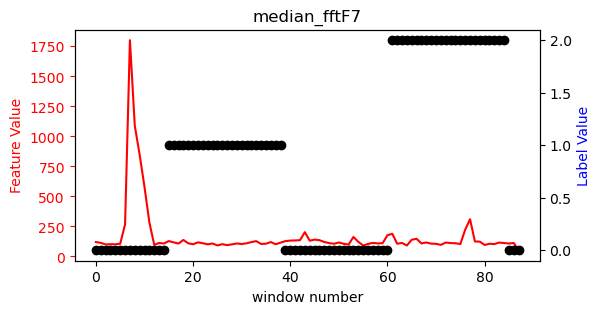

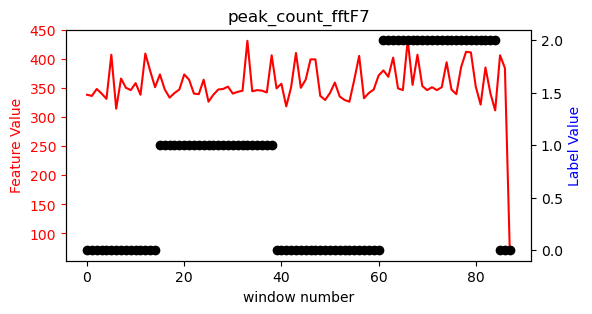

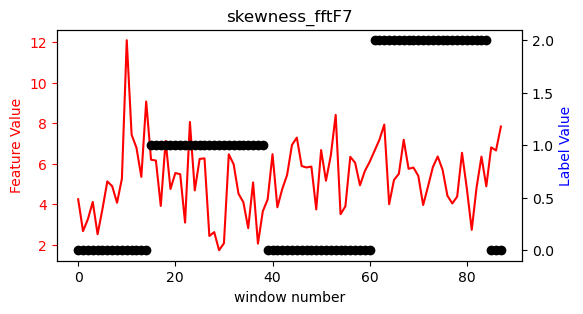

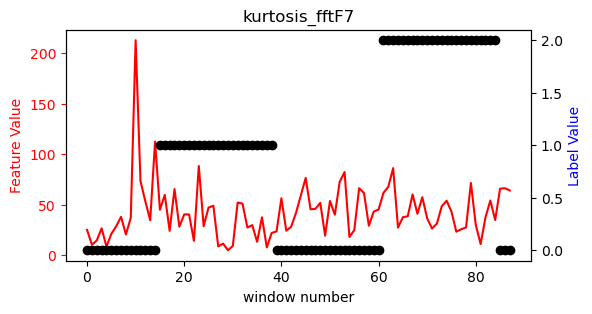

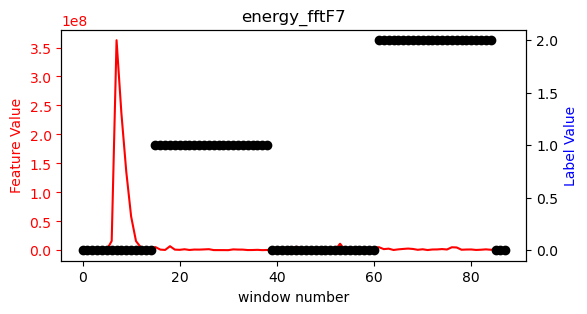

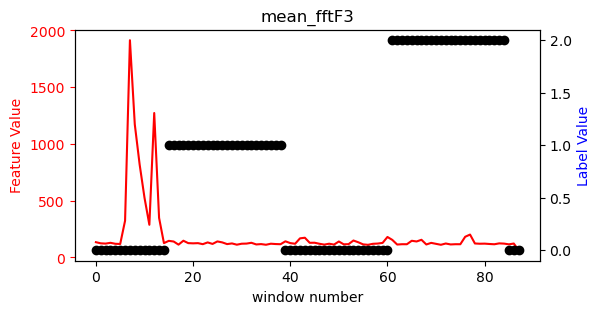

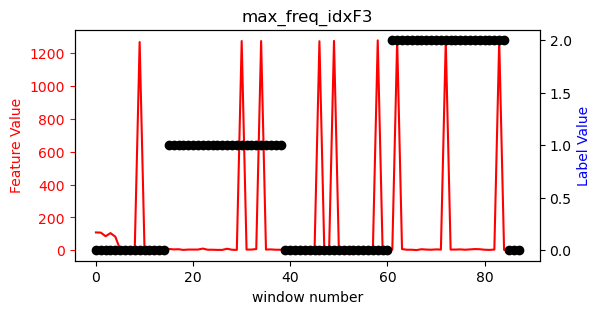

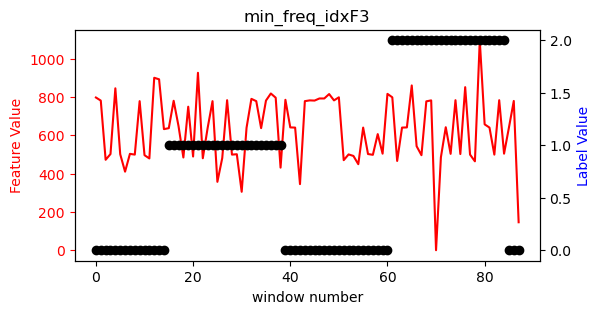

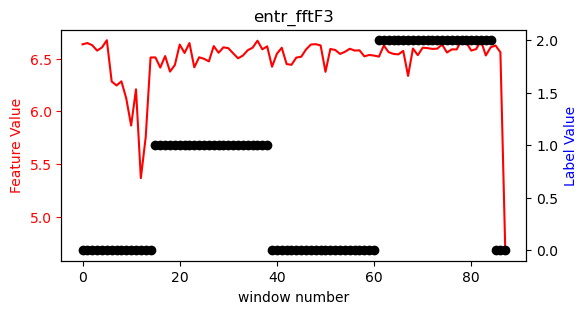

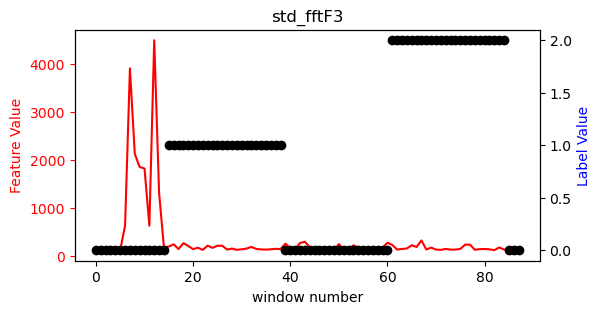

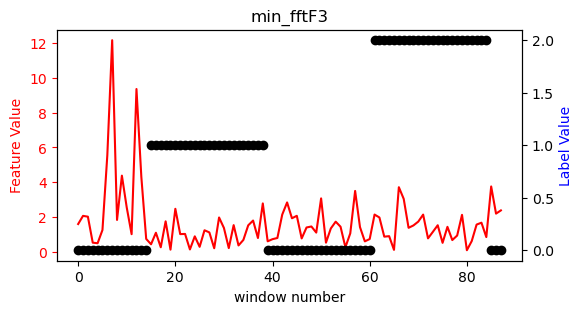

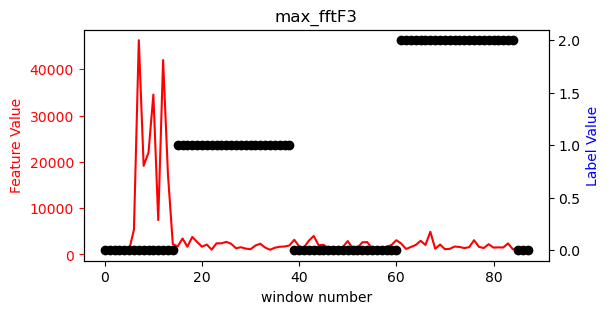

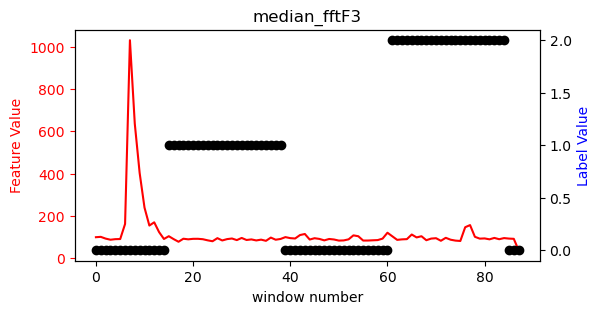

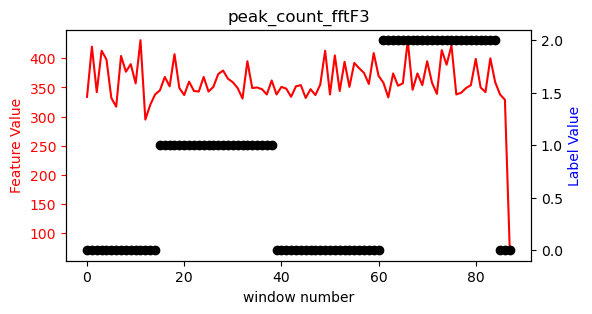

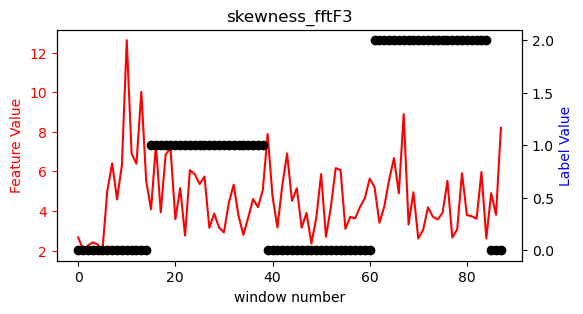

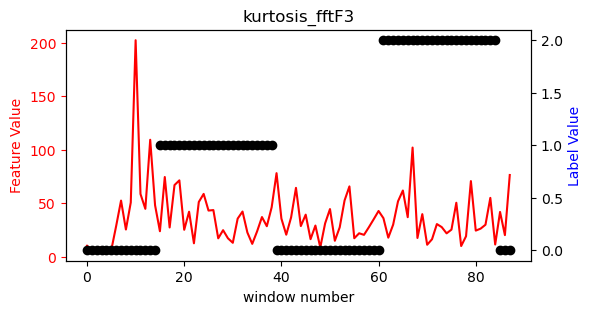

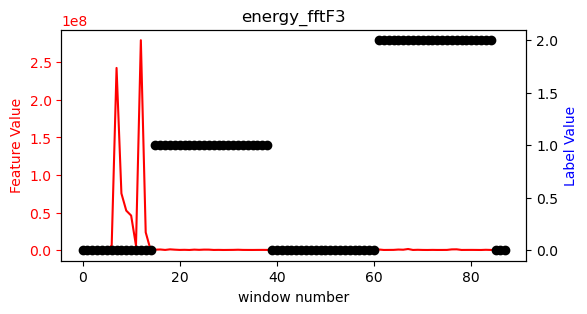

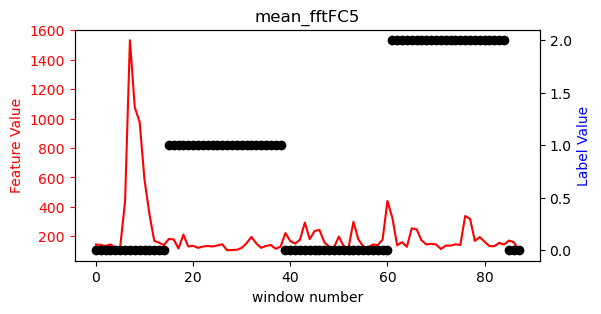

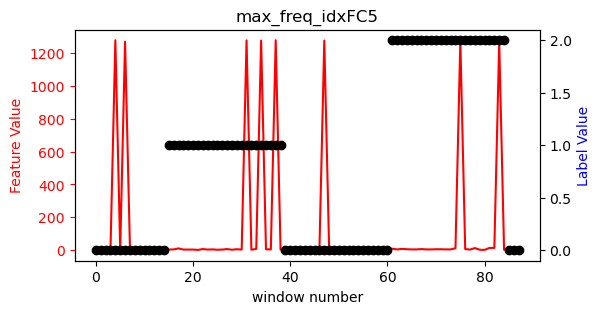

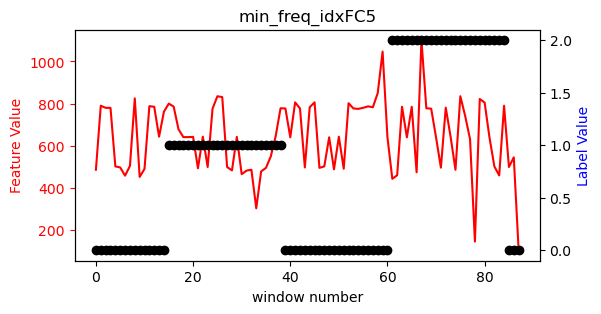

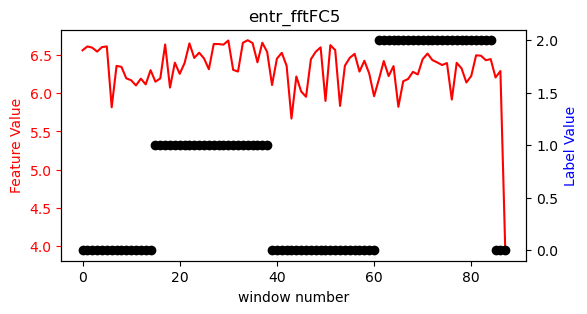

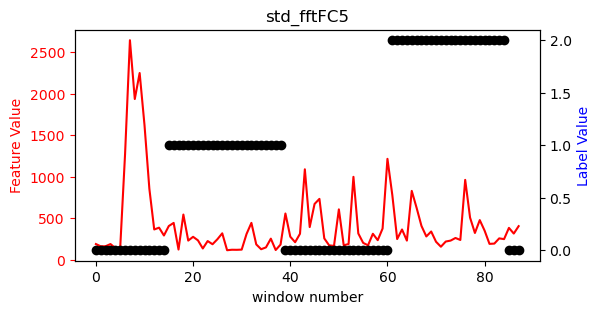

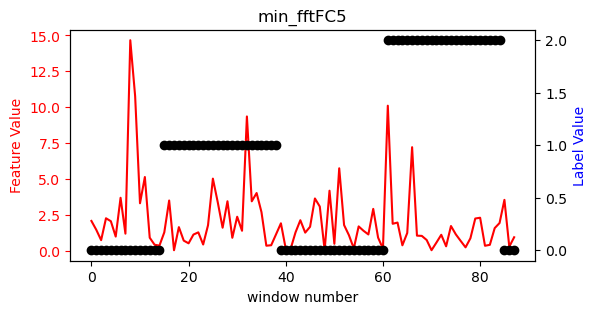

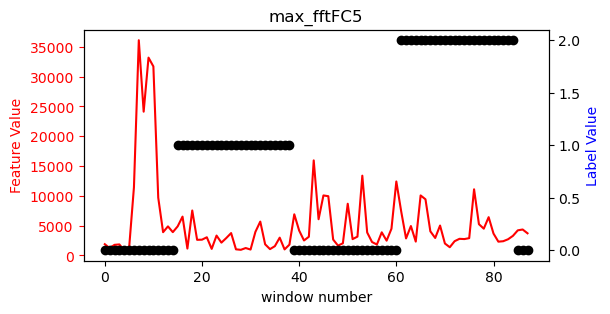

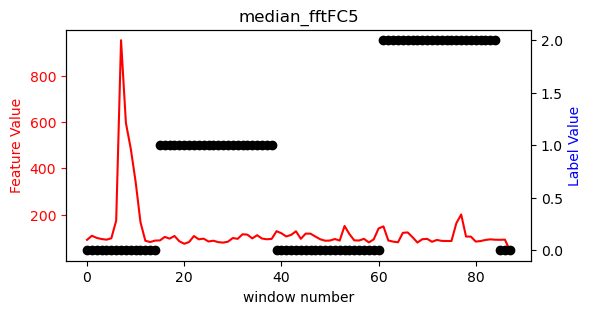

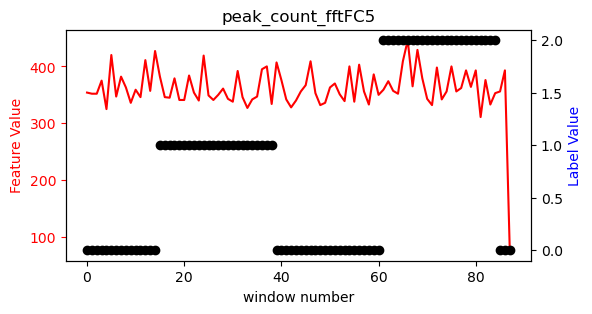

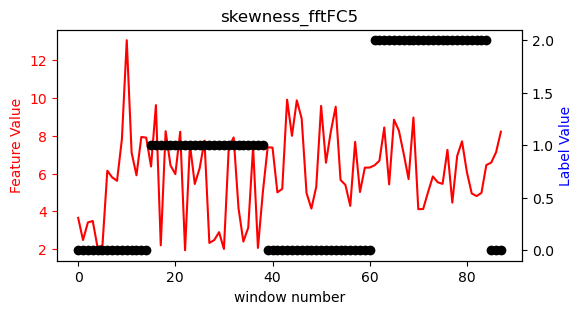

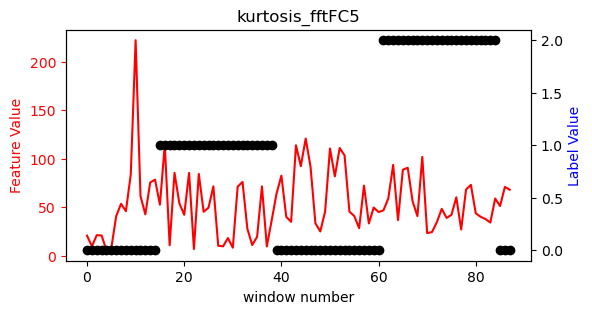

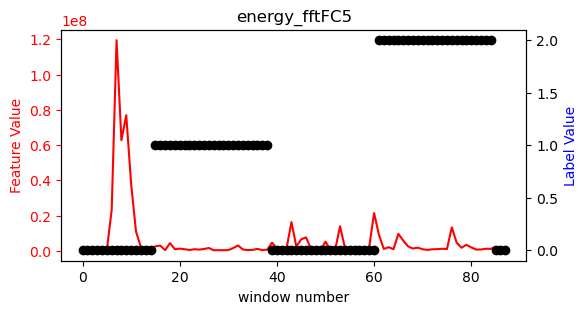

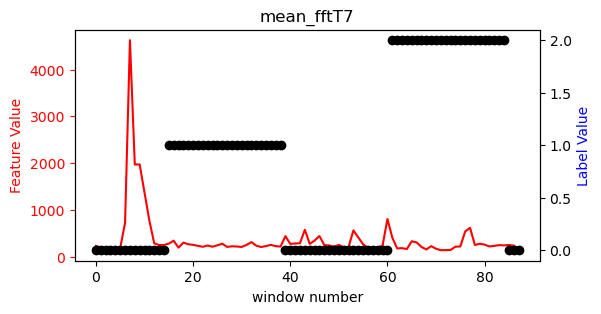

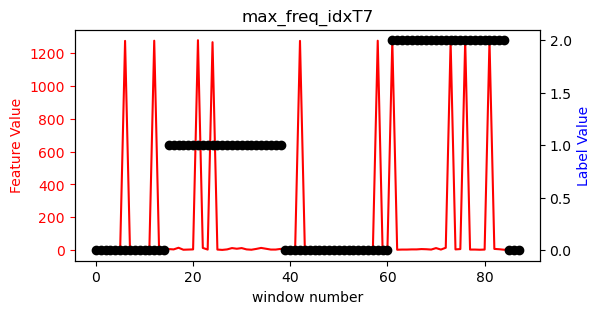

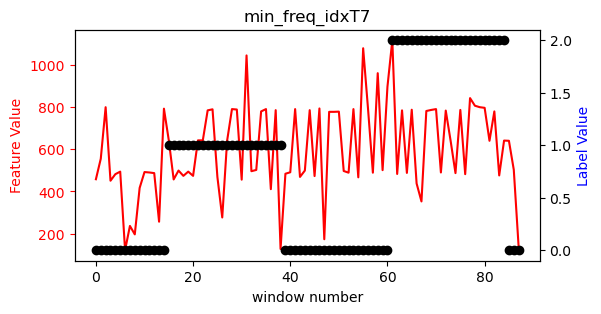

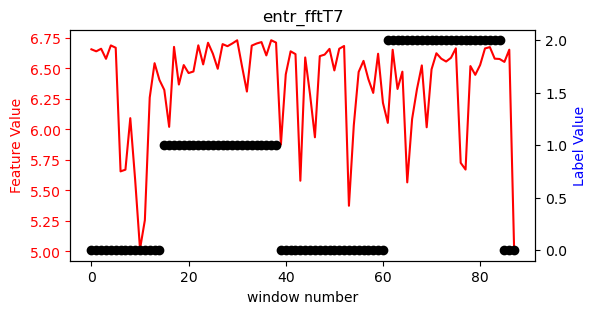

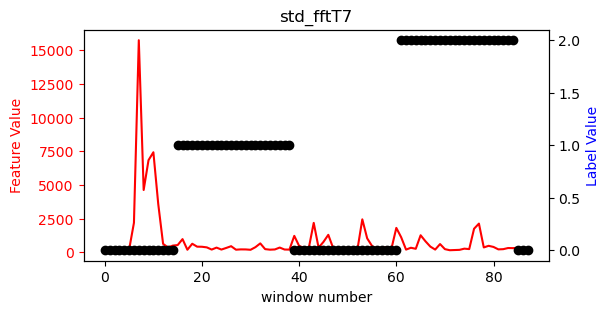

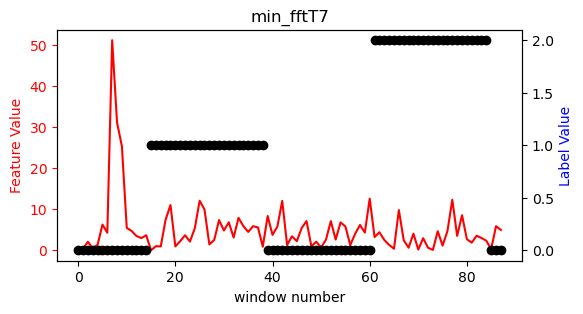

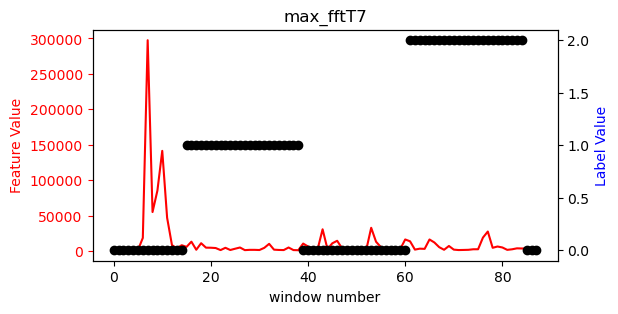

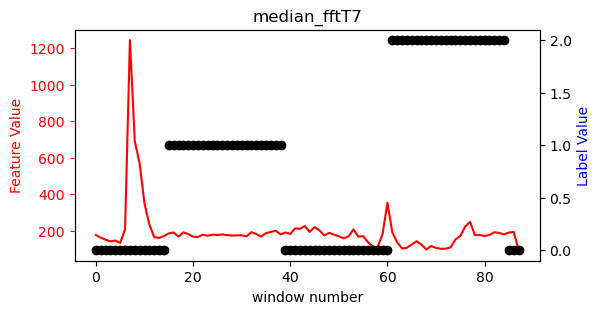

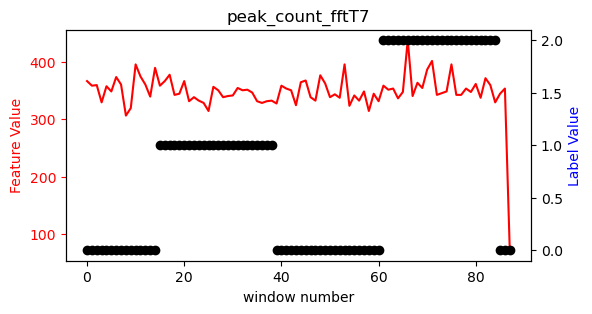

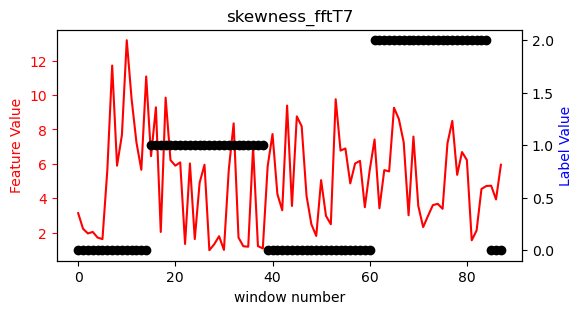

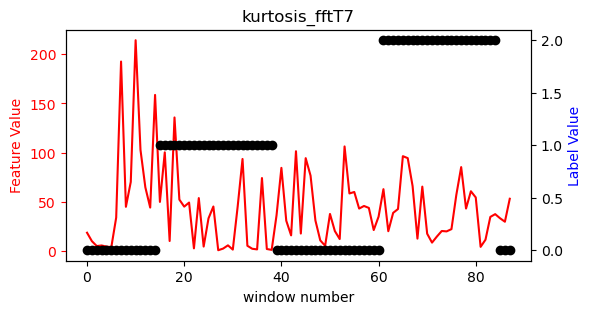

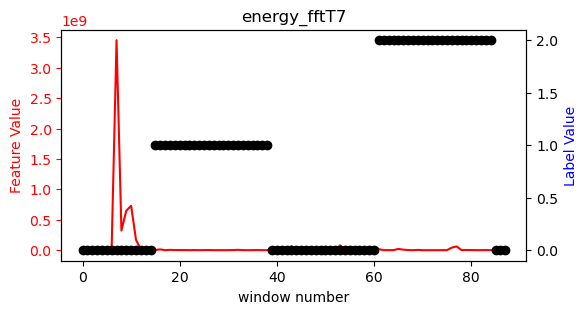

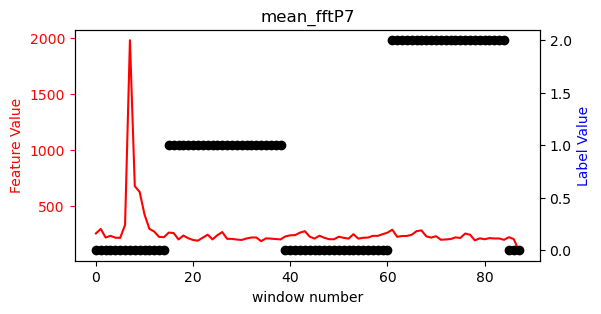

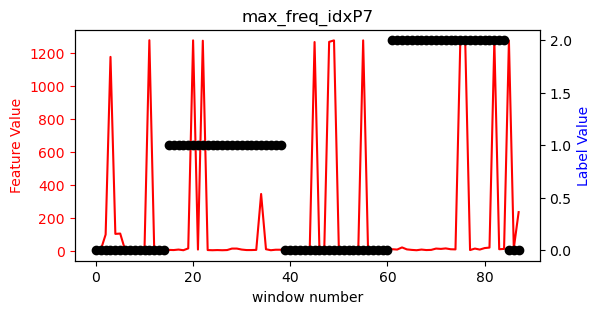

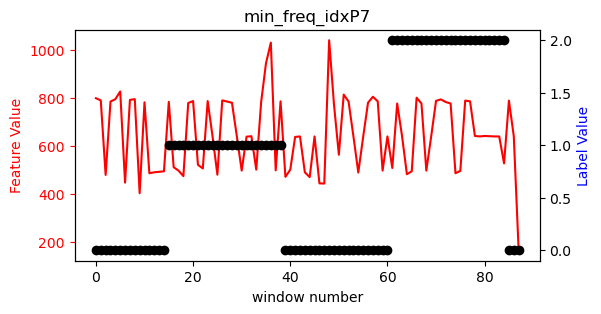

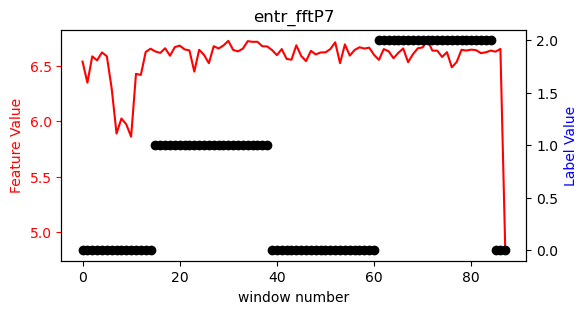

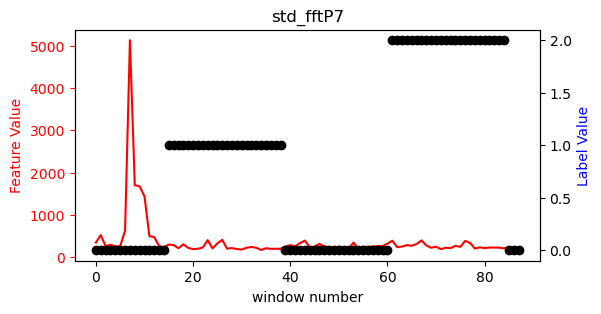

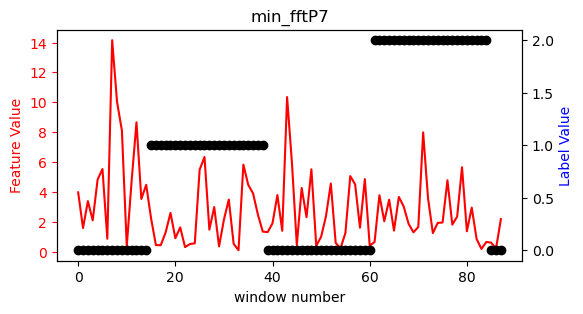

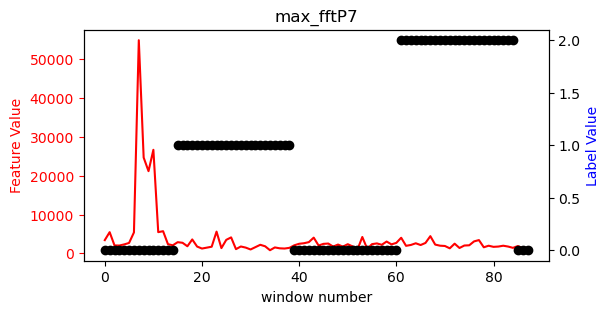

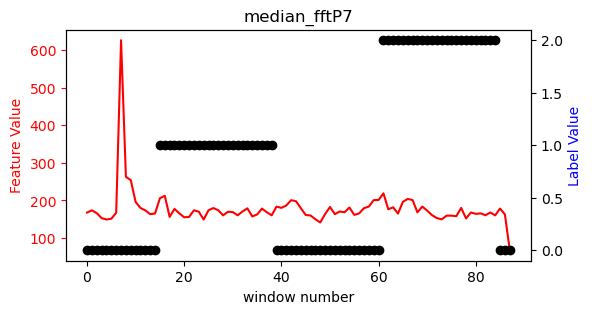

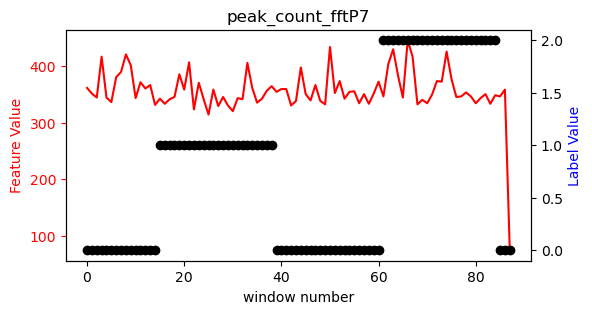

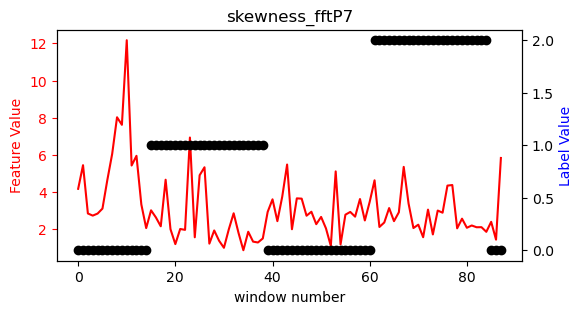

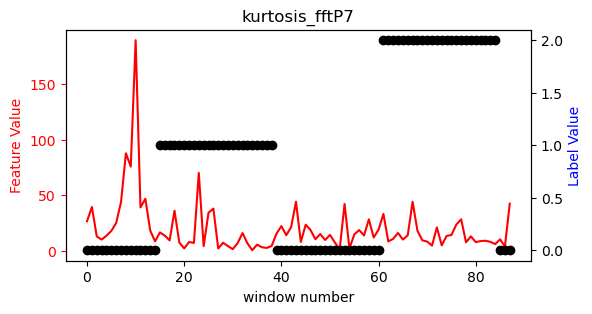

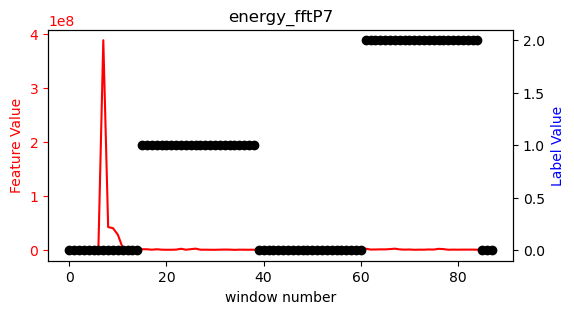

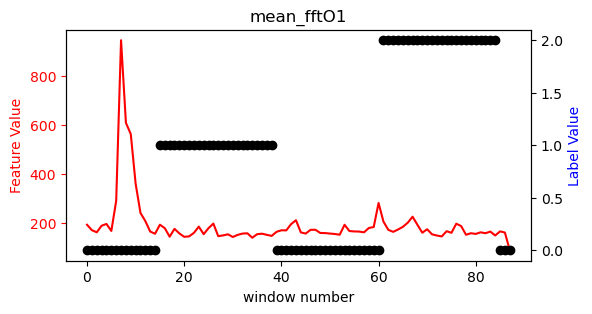

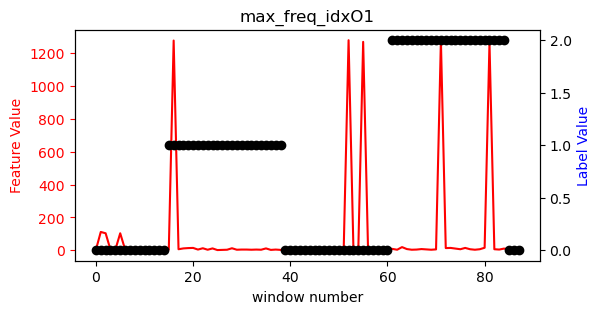

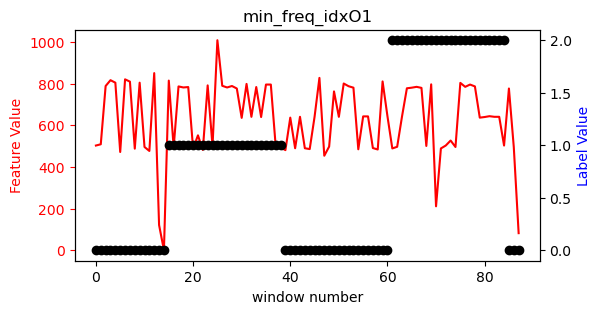

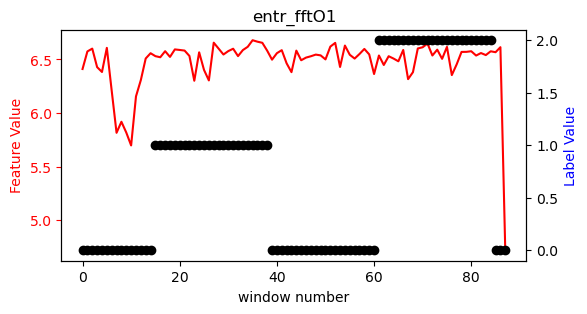

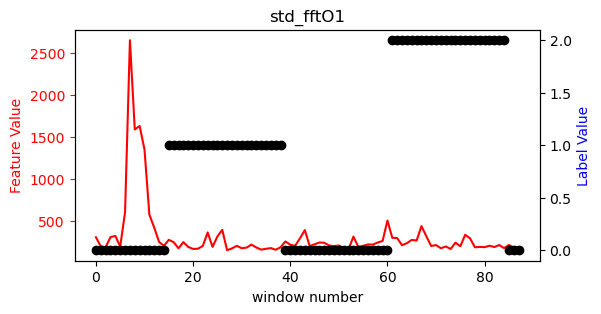

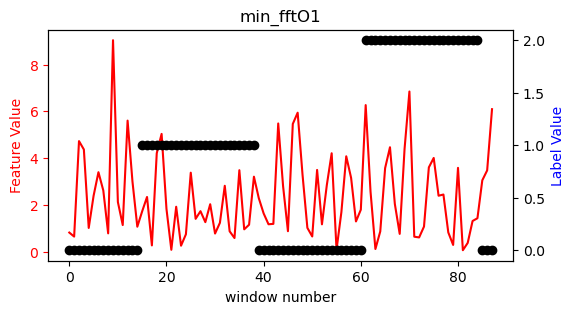

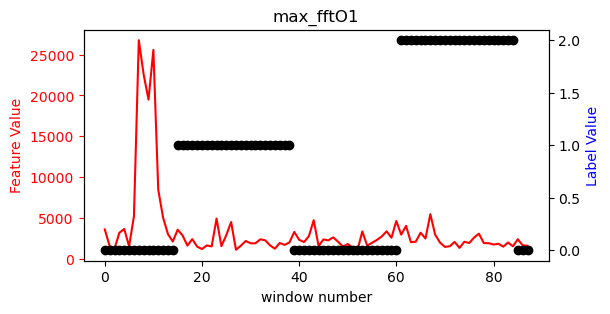

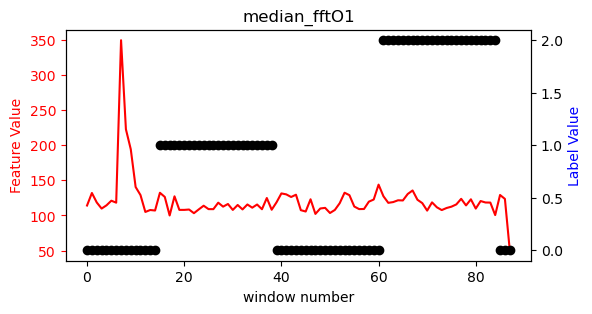

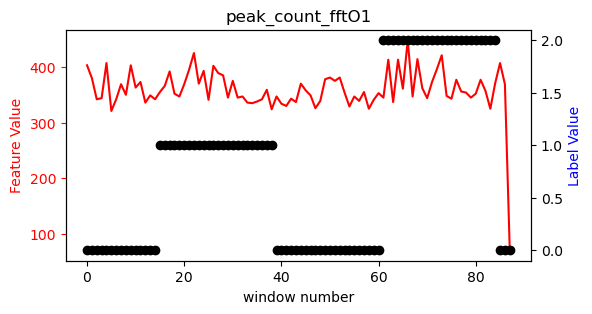

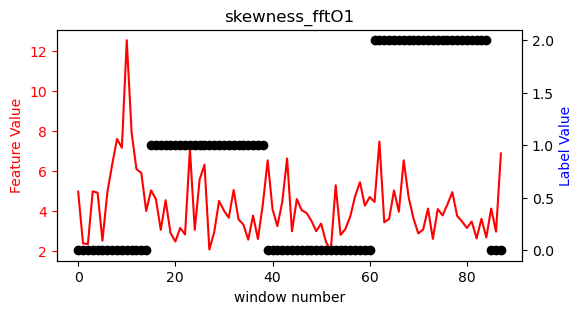

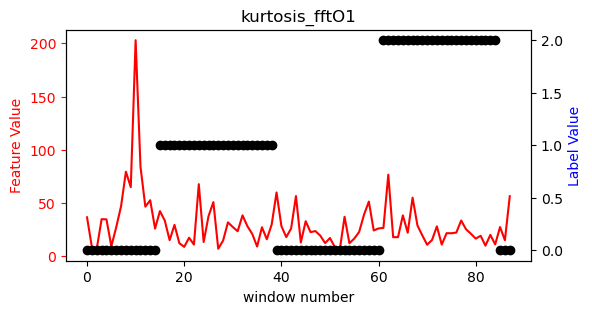

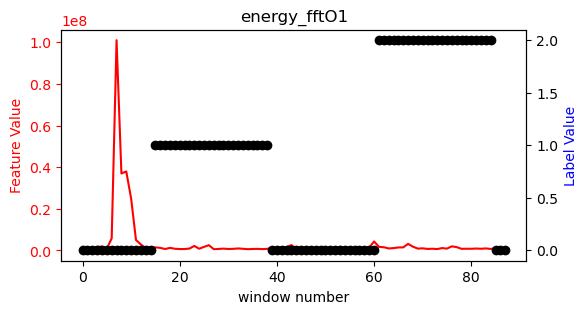

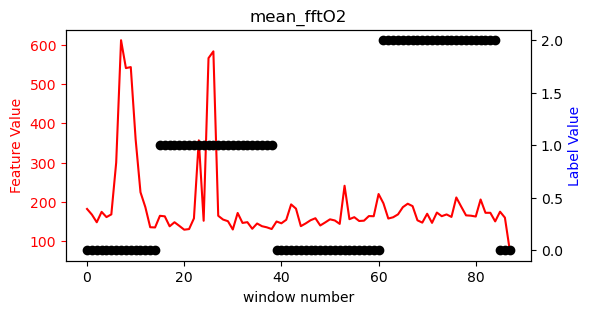

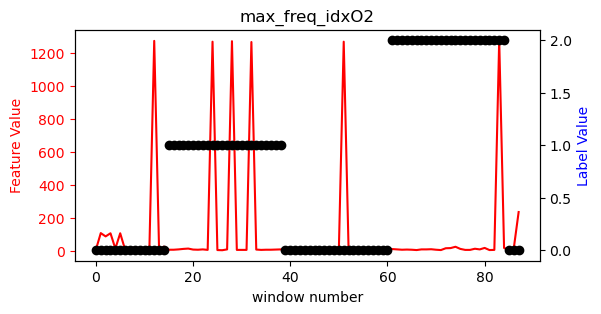

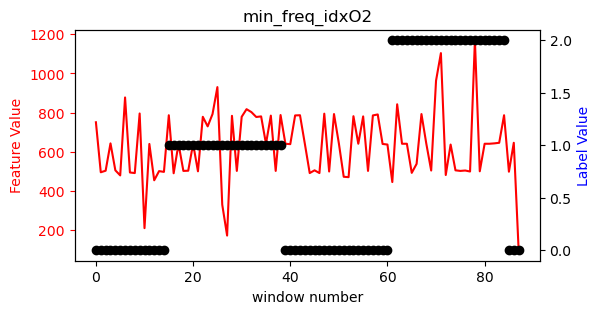

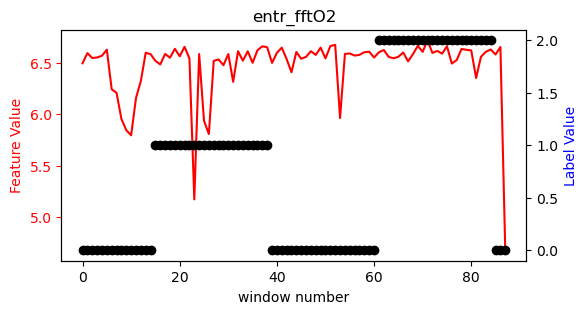

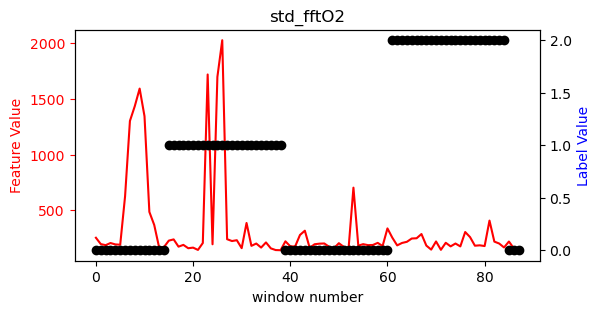

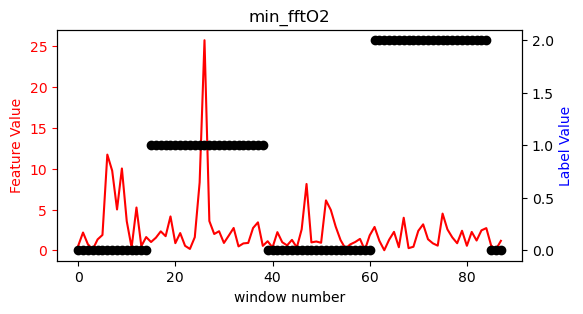

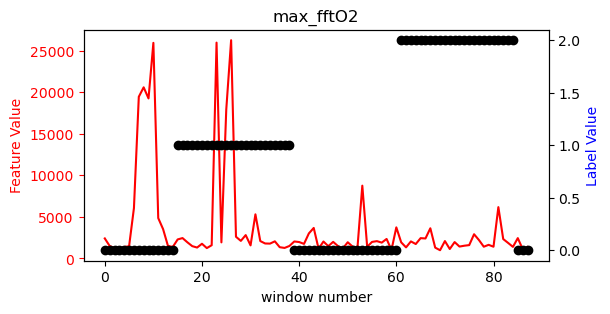

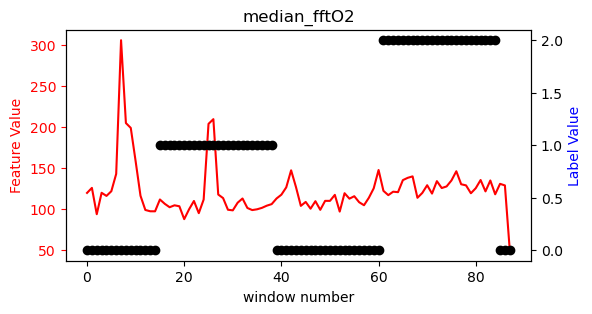

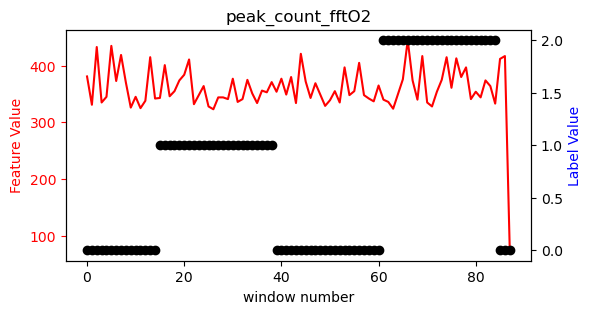

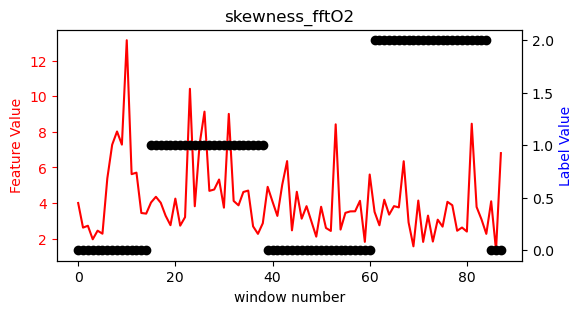

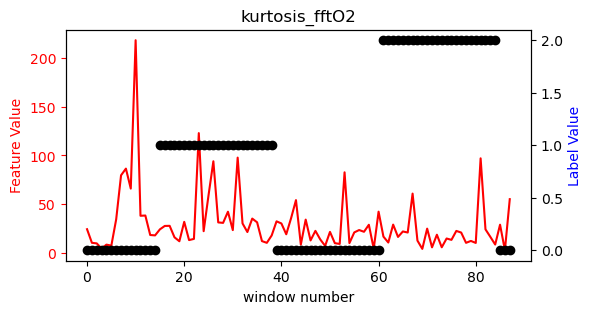

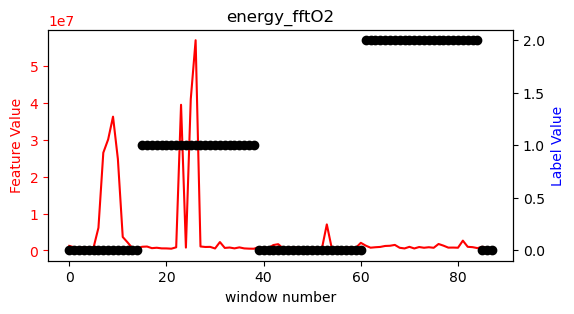

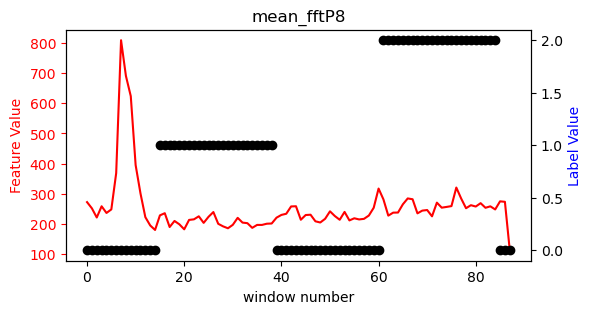

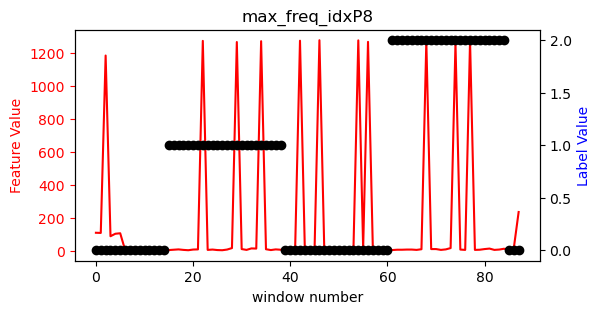

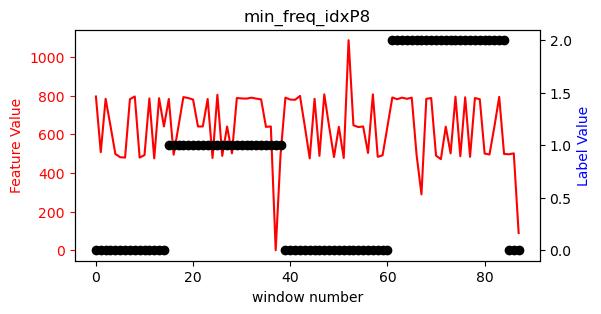

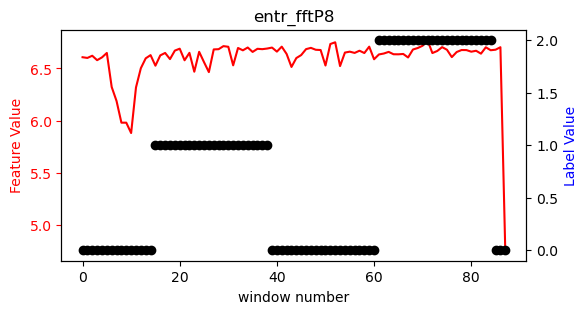

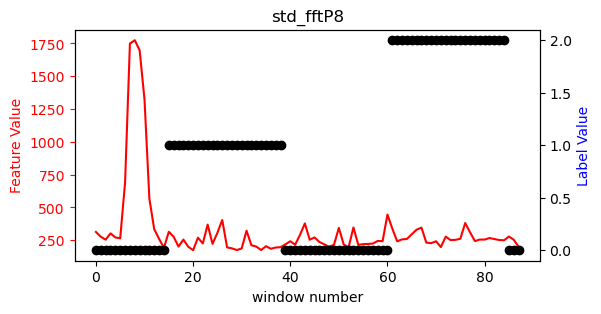

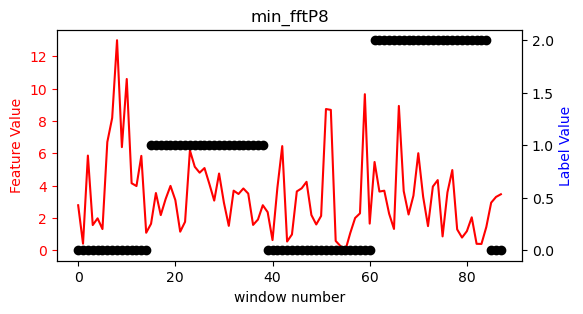

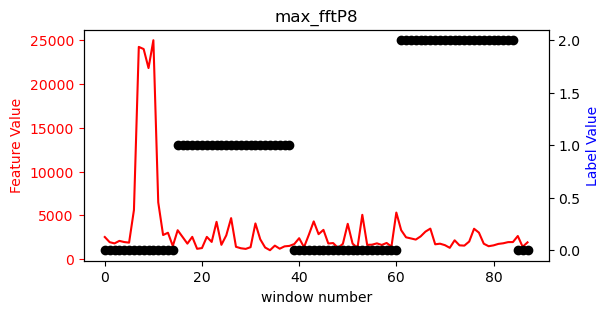

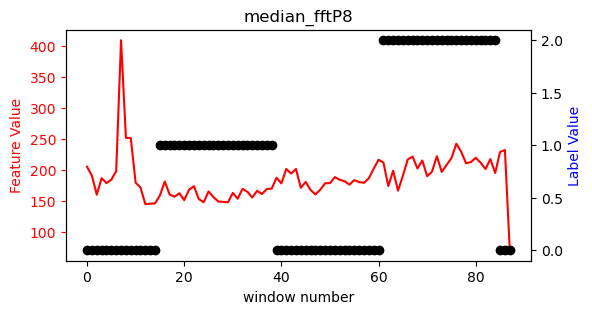

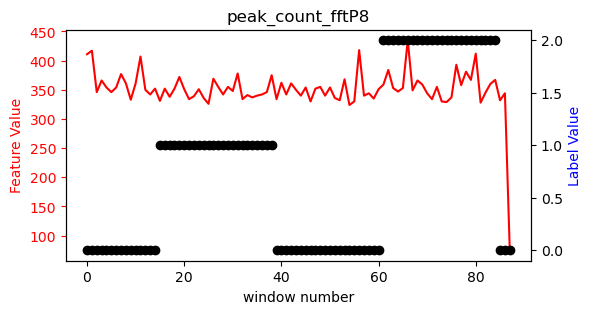

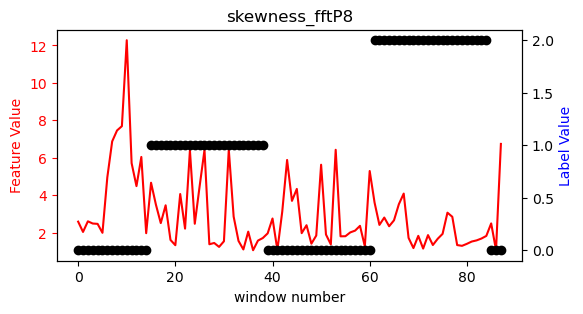

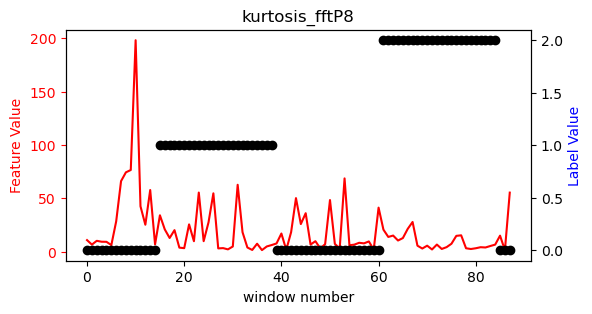

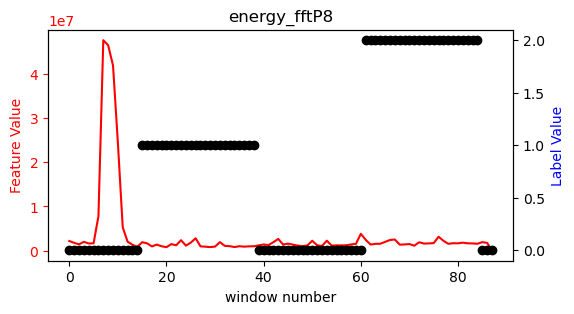

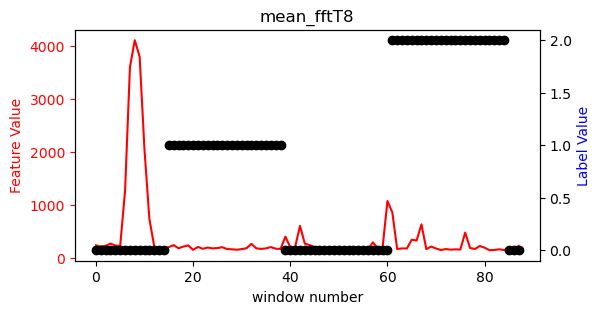

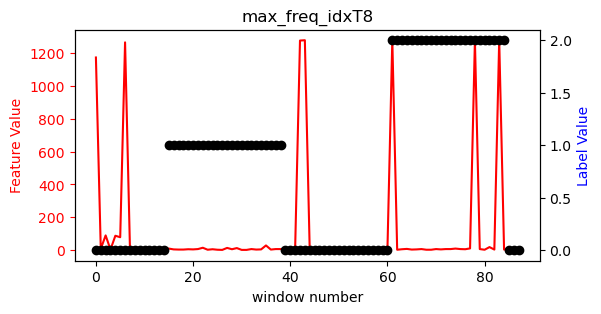

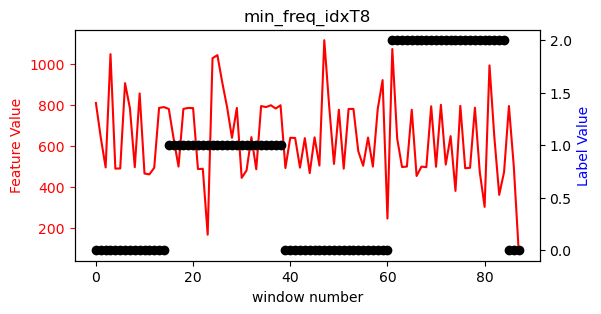

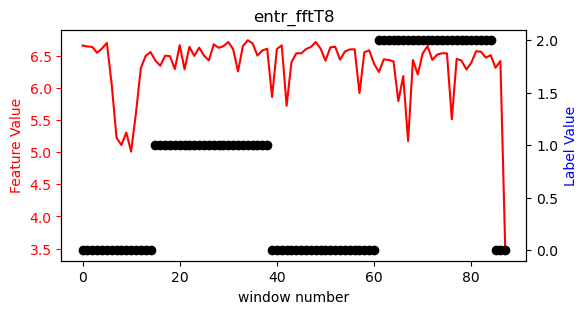

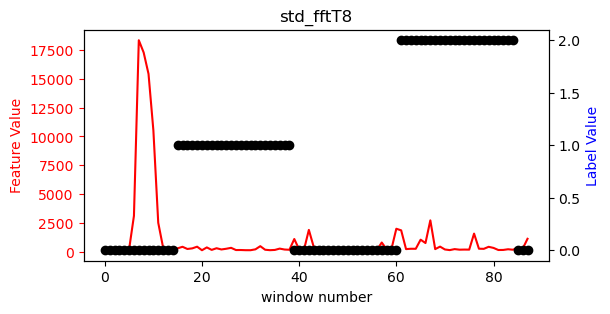

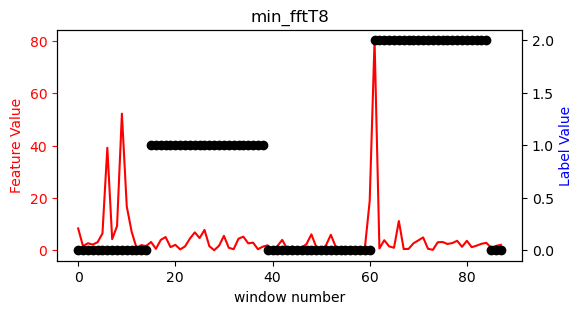

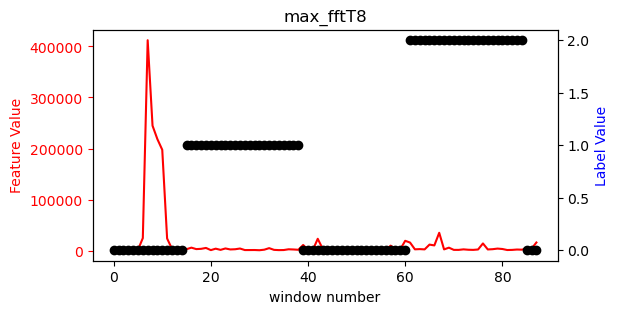

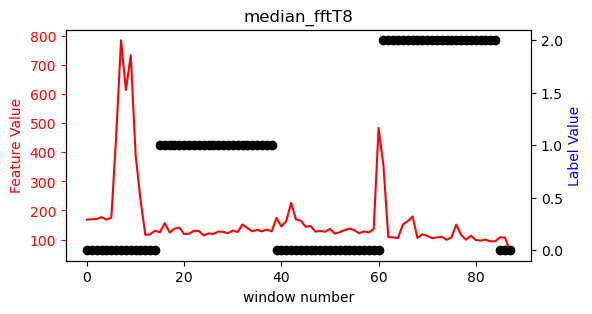

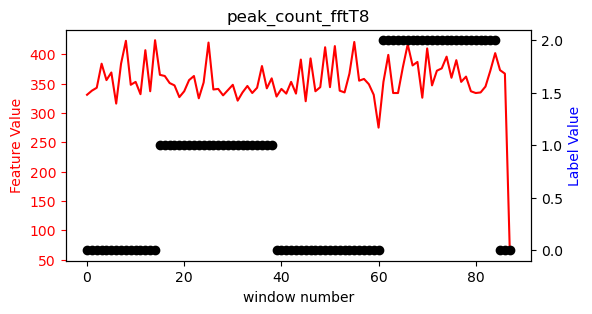

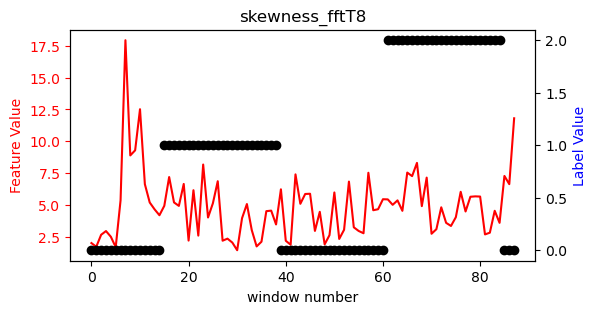

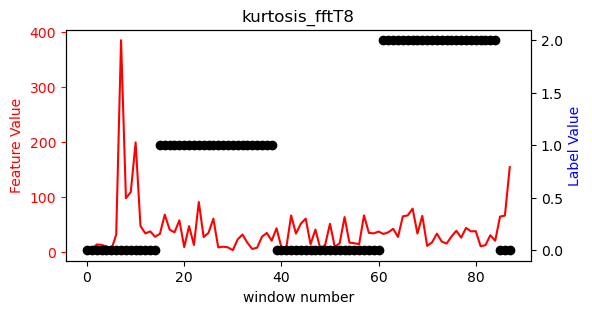

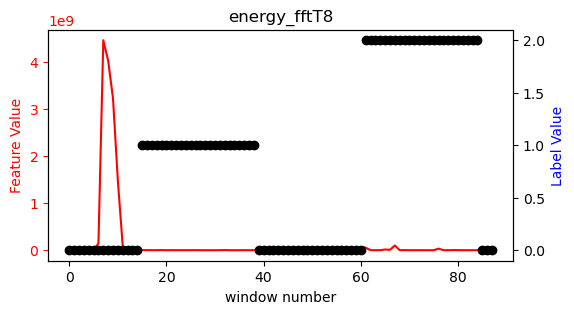

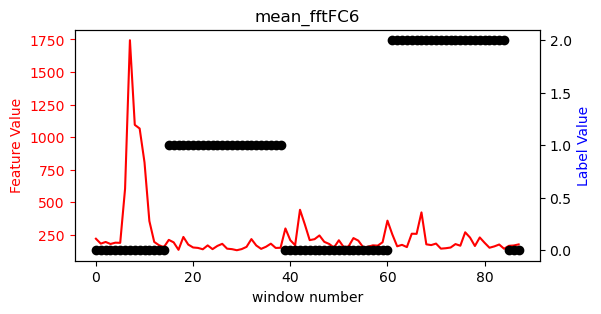

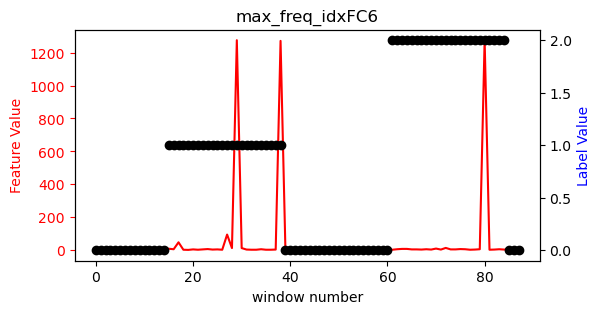

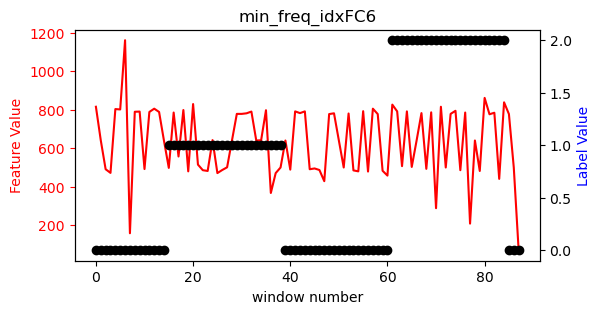

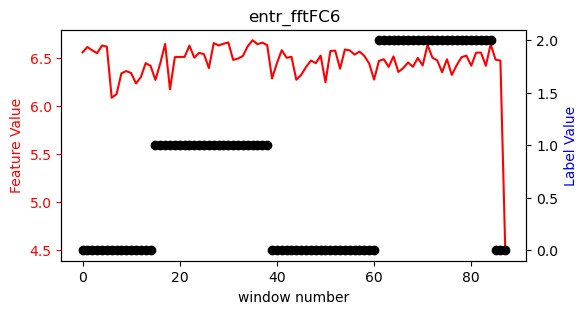

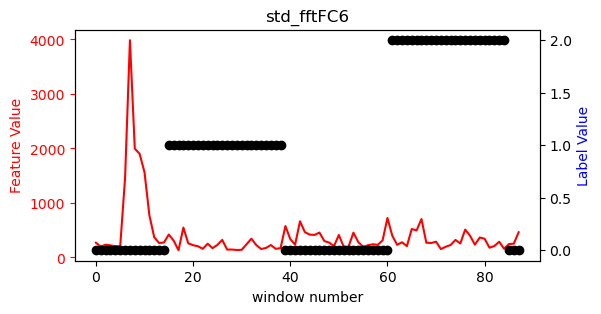

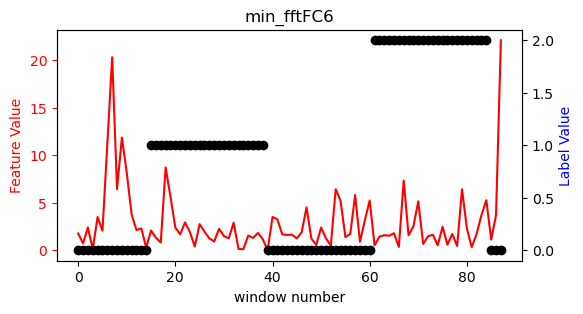

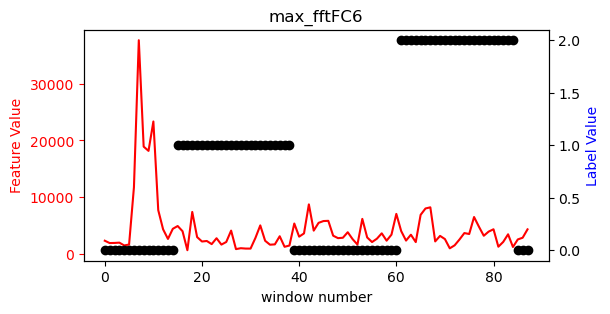

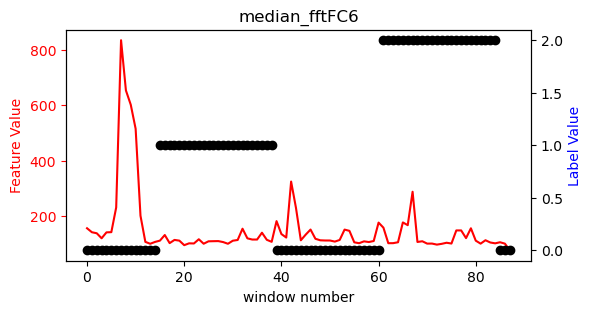

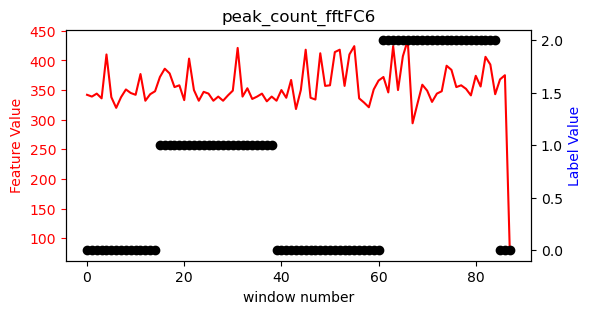

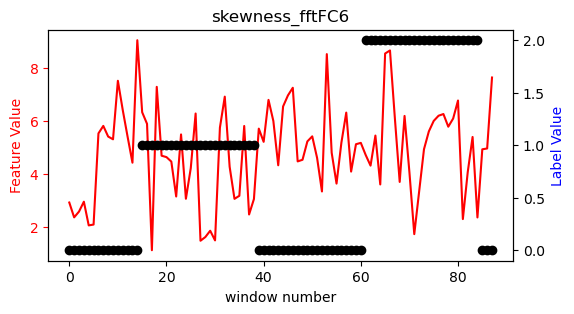

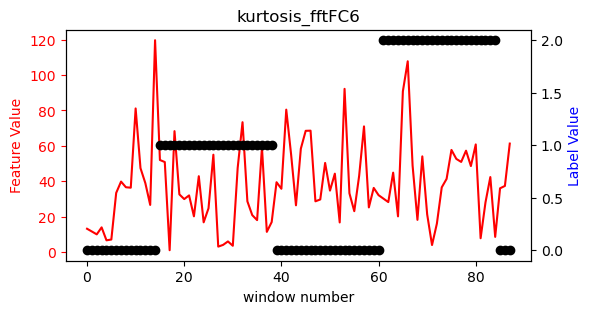

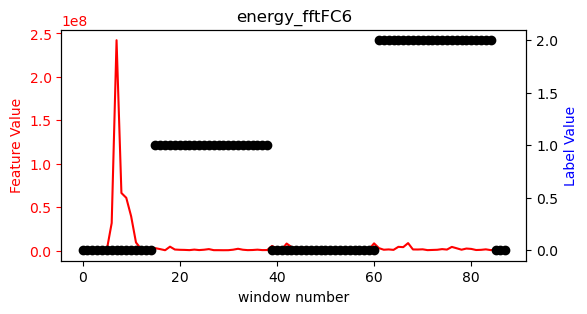

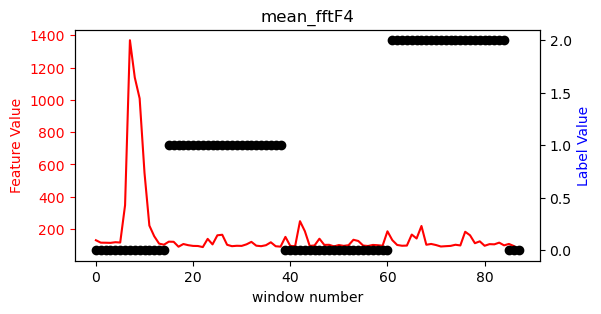

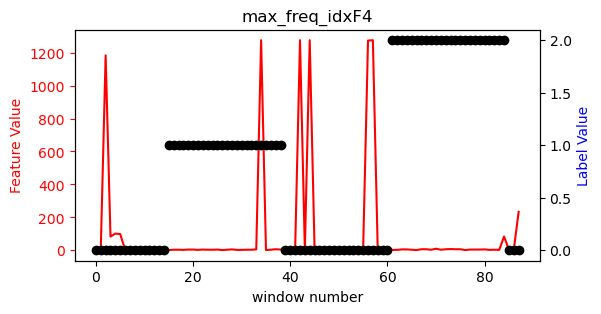

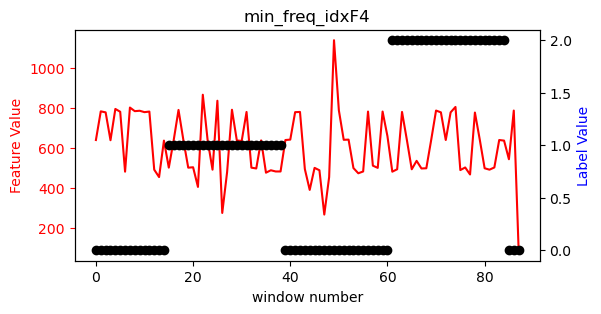

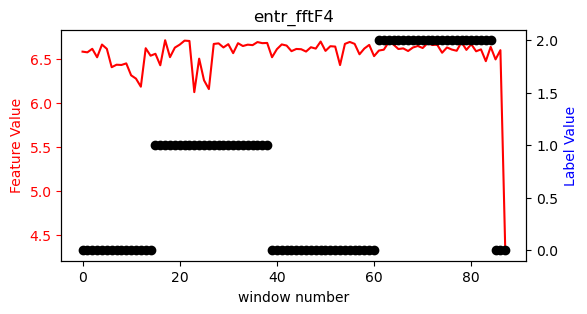

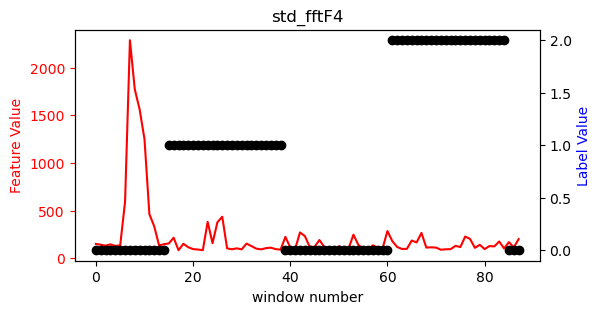

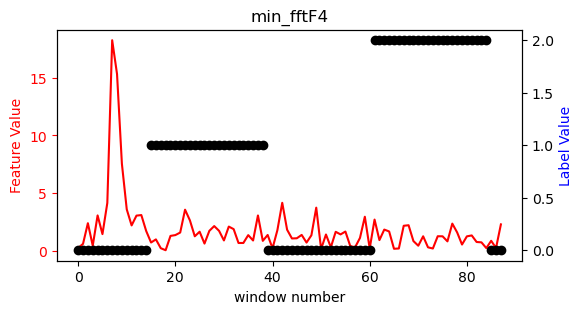

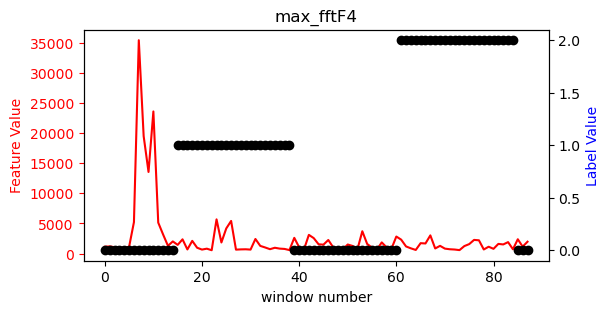

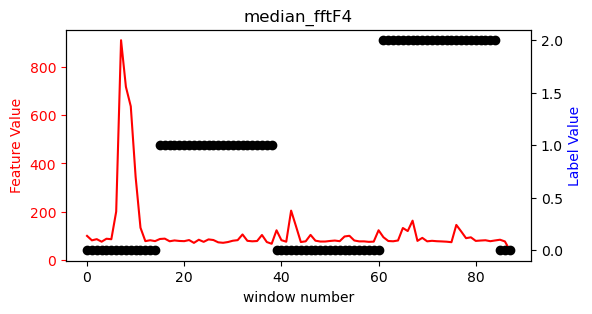

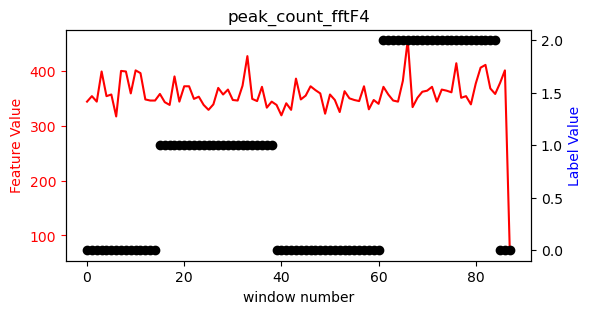

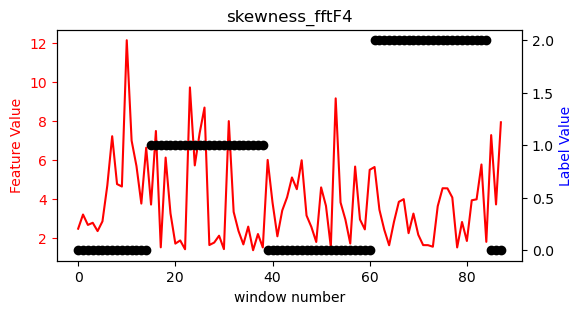

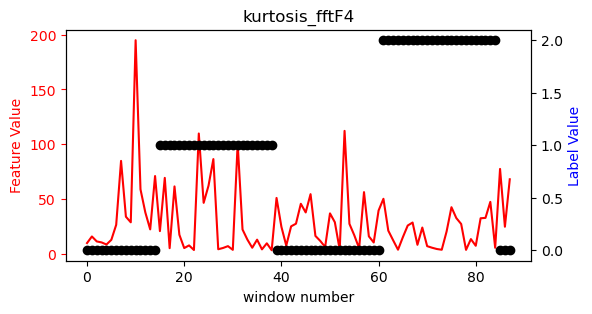

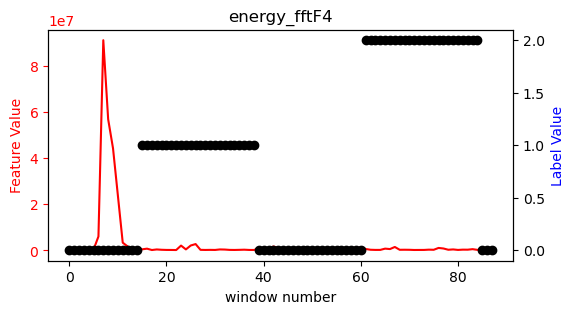

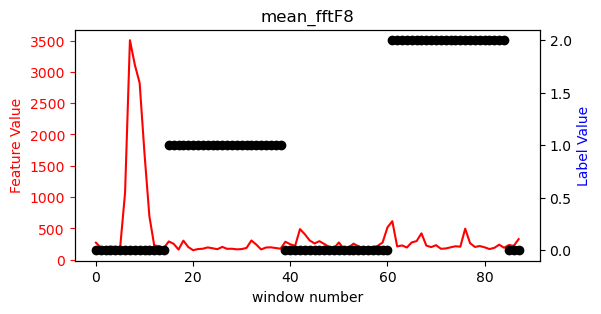

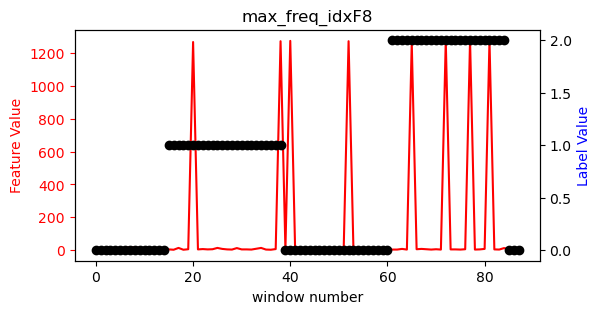

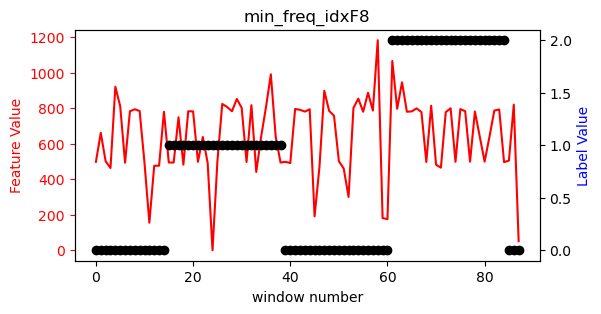

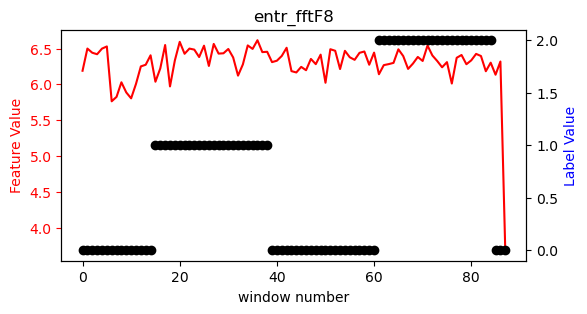

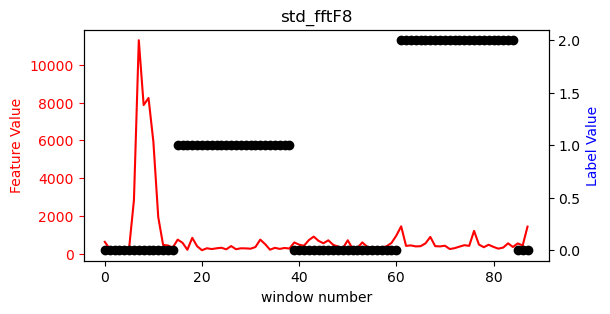

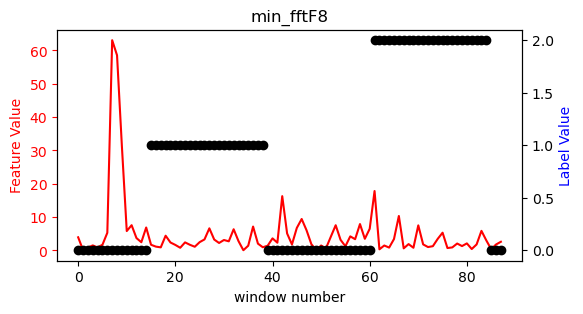

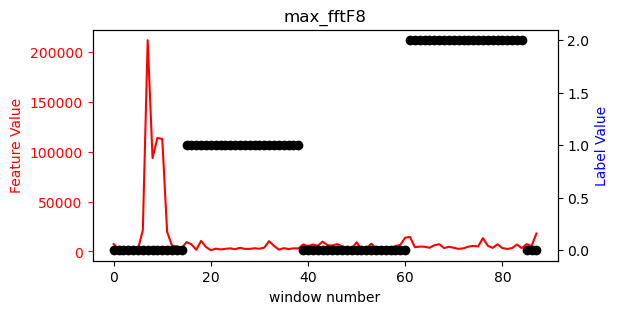

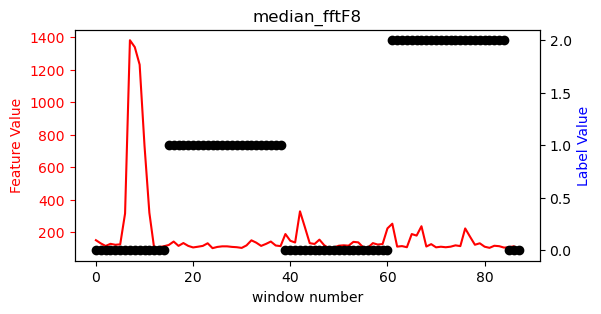

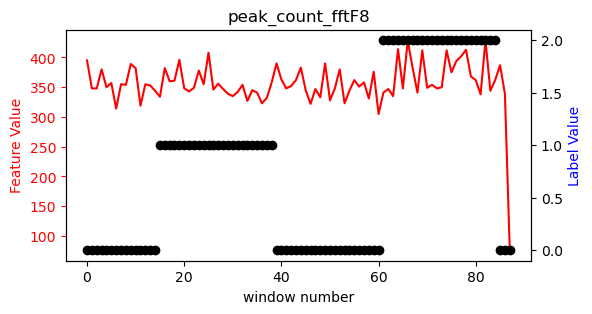

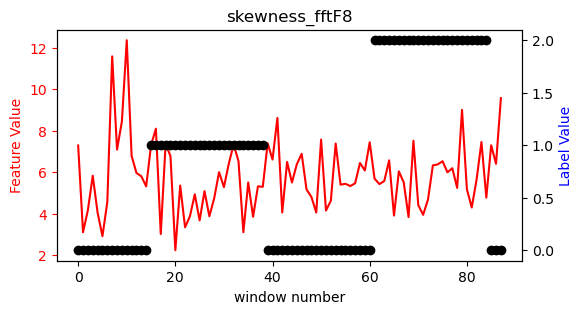

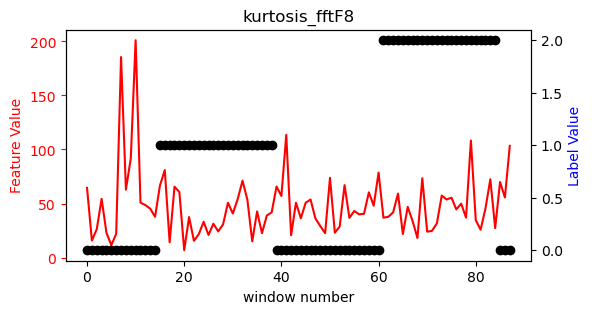

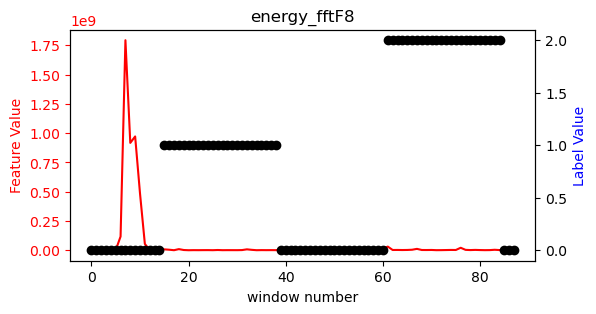

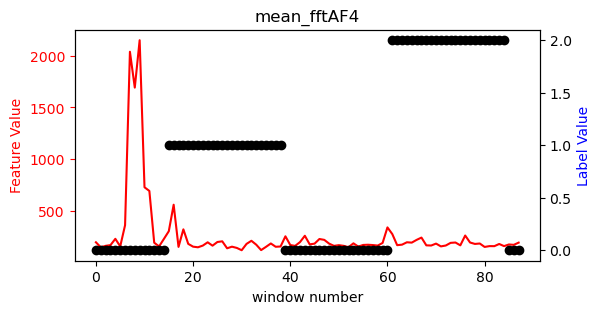

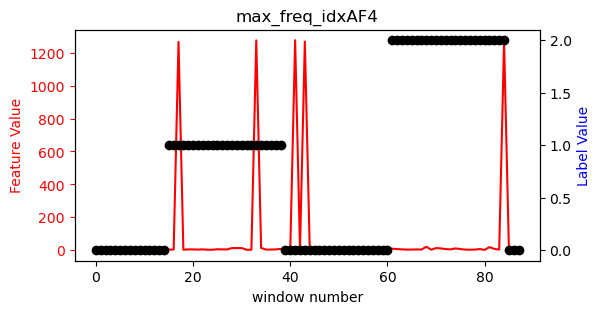

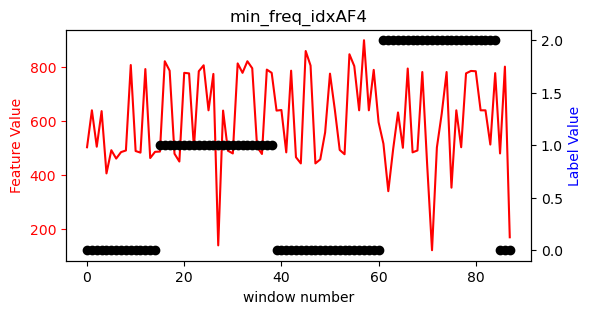

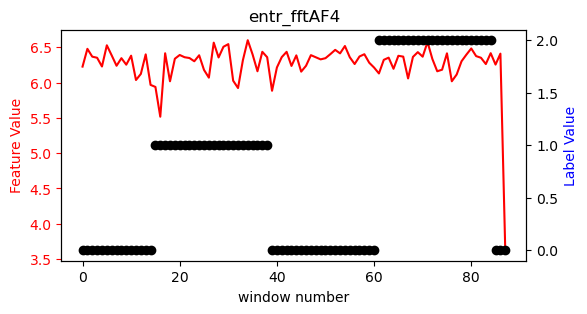

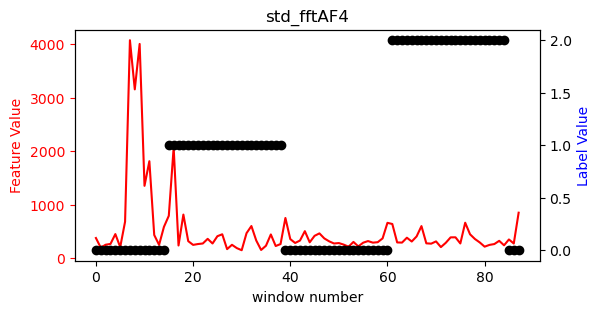

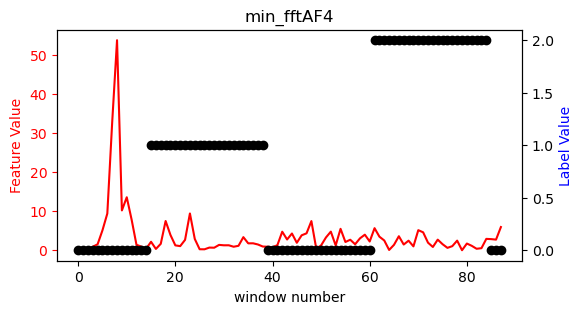

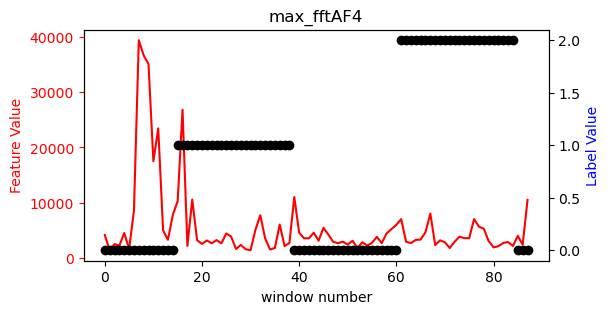

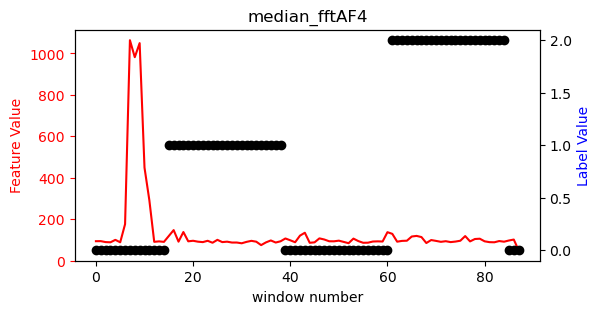

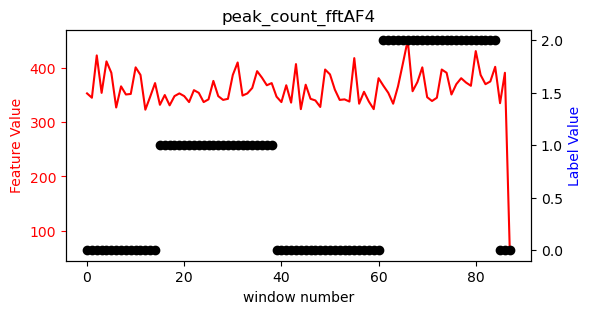

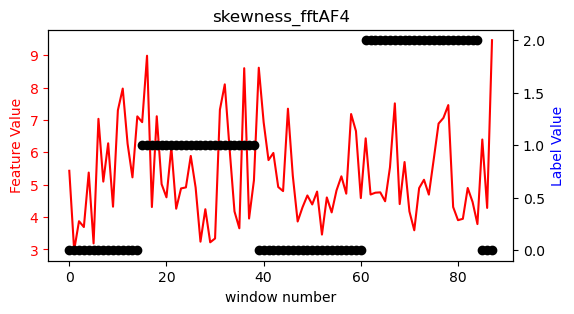

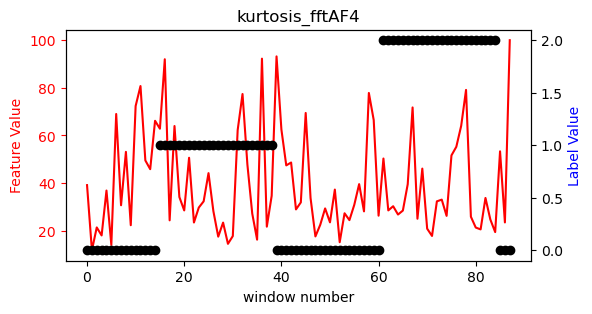

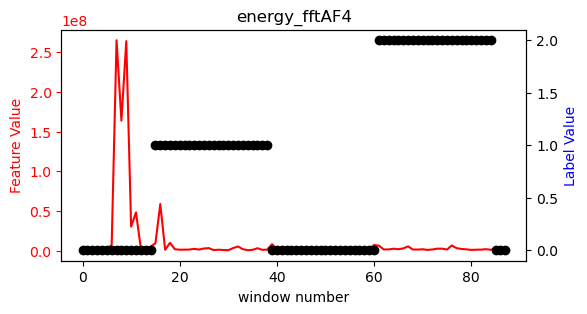

In [18]:
for i in features.columns:
    fig, ax1 = plt.subplots(figsize=(6, 3))
    # Plot the first data on the first axes
    ax1.plot(features[i],'r',linewidth=1.5)
    ax1.set_xlabel('window number')
    ax1.set_ylabel('Feature Value', color='red')
    ax1.tick_params('y', colors='red')
    ax2 = ax1.twinx()
    # Plot the second data on the second axes
    ax2.plot(label_list,'o', color='black')
    ax2.set_ylabel('Label Value', color='blue',)
    #ax2.tick_params('y', colors='blue')
    plt.title(i)
    plt.show()

              precision    recall  f1-score   support

           0       0.80      0.62      0.70       108
           1       0.84      0.89      0.86       122
           2       0.81      0.94      0.87       103

    accuracy                           0.82       333
   macro avg       0.81      0.82      0.81       333
weighted avg       0.82      0.82      0.81       333



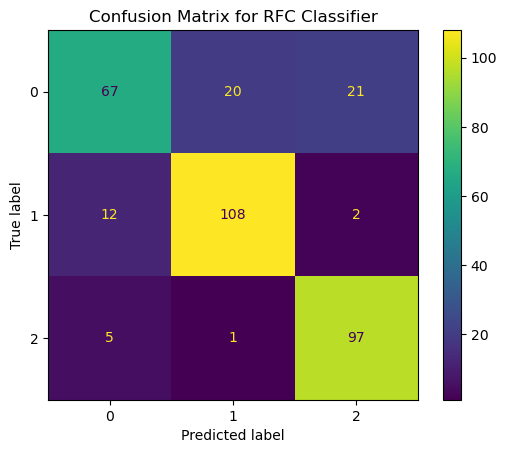

              precision    recall  f1-score   support

           0       0.72      0.65      0.68       121
           1       0.78      0.81      0.79       121
           2       0.81      0.85      0.83       123

    accuracy                           0.77       365
   macro avg       0.77      0.77      0.77       365
weighted avg       0.77      0.77      0.77       365



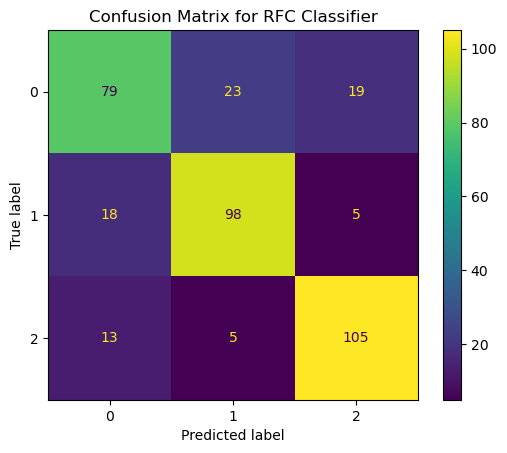

              precision    recall  f1-score   support

           0       0.77      0.67      0.71       142
           1       0.76      0.82      0.79       127
           2       0.84      0.89      0.87       133

    accuracy                           0.79       402
   macro avg       0.79      0.79      0.79       402
weighted avg       0.79      0.79      0.79       402



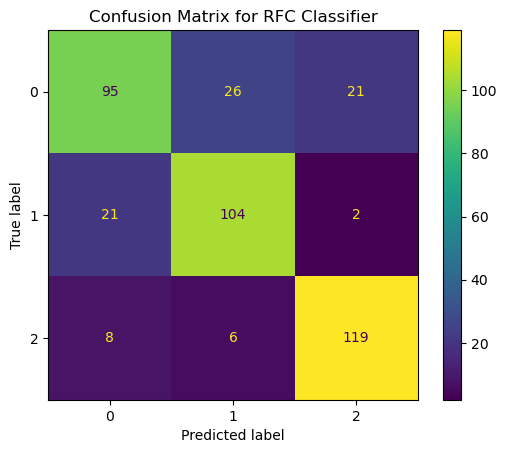

              precision    recall  f1-score   support

           0       0.78      0.61      0.69       145
           1       0.78      0.84      0.81       142
           2       0.80      0.91      0.85       147

    accuracy                           0.79       434
   macro avg       0.79      0.79      0.78       434
weighted avg       0.79      0.79      0.78       434



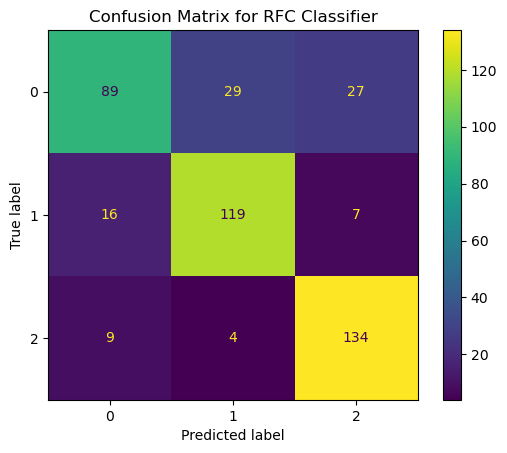

              precision    recall  f1-score   support

           0       0.74      0.58      0.65       156
           1       0.84      0.84      0.84       172
           2       0.72      0.90      0.80       139

    accuracy                           0.77       467
   macro avg       0.77      0.77      0.76       467
weighted avg       0.77      0.77      0.76       467



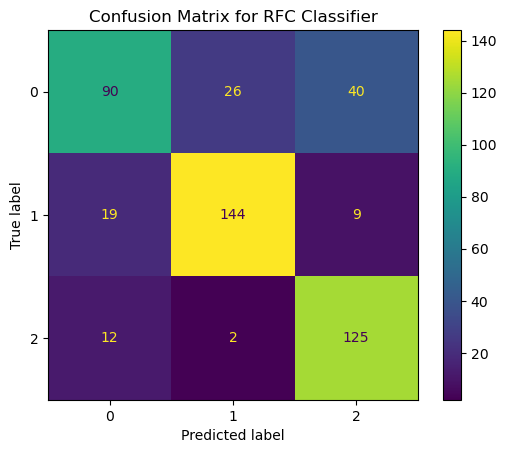

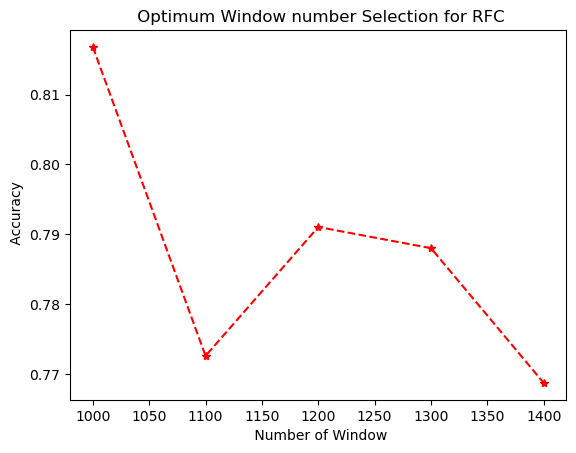

In [20]:
##RFC
no_of_windows=range(1000, 1500, 100)
#no_of_windows=[300]
score=np.zeros(len(no_of_windows));
from sklearn.metrics import accuracy_score
for i in range(len(no_of_windows)):
    window_size=int(len(merged_data)/no_of_windows[i])
    
    X, label_list = window_partition(merged_data, window_size, overlap=0, column_names=['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6',
       'F4', 'F8', 'AF4'])
    from sklearn.metrics import classification_report as rprt
    smote = SMOTE(random_state=42) 
    scaler=StandardScaler()
    X=scaler.fit_transform(X)
    X_resampled, y_resampled = smote.fit_resample(X, label_list)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25)
    model=rfc(max_depth=12,n_estimators=100  )
    rfc_model=model.fit(X_train, y_train)
    y_prd=rfc_model.predict(X_test)
    print(rprt(y_test, y_prd))
    score[i]=accuracy_score(y_test, y_prd)
    cm = confusion_matrix(y_test, y_prd)
    cm_display = metrics.ConfusionMatrixDisplay(cm).plot()
    plt.title("Confusion Matrix for RFC Classifier")
    plt.show()
plt.plot(no_of_windows, score,'--r*' )
plt.xlabel(' Number of Window' )
plt.ylabel(' Accuracy')
plt.title(' Optimum Window number Selection for RFC')
plt.show()
#Retrieve feature importance scores for RFC



mean_fftAF3: 0.006020623332220472
max_freq_idxAF3: 0.0029201167358746255
min_freq_idxAF3: 0.0029699353580837475
entr_fftAF3: 0.005074280488088876
std_fftAF3: 0.004909843386364814
min_fftAF3: 0.00458229161969758
max_fftAF3: 0.003858968351838814
median_fftAF3: 0.005344617295055249
peak_count_fftAF3: 0.002742520522768378
skewness_fftAF3: 0.00392418663553007
kurtosis_fftAF3: 0.003557453196322108
energy_fftAF3: 0.005040565981664214
mean_fftF7: 0.005165067064414806
max_freq_idxF7: 0.0017129633580276096
min_freq_idxF7: 0.0019359604098849012
entr_fftF7: 0.003484329580599355
std_fftF7: 0.009280155680538554
min_fftF7: 0.004733343973321588
max_fftF7: 0.007227797063694921
median_fftF7: 0.003392519001564579
peak_count_fftF7: 0.0028034740422551597
skewness_fftF7: 0.005489660909196051
kurtosis_fftF7: 0.00511346617120001
energy_fftF7: 0.010699918776808036
mean_fftF3: 0.006364377573809469
max_freq_idxF3: 0.0039669634834190925
min_freq_idxF3: 0.0015354427582353542
entr_fftF3: 0.00713335122479265
std_fft

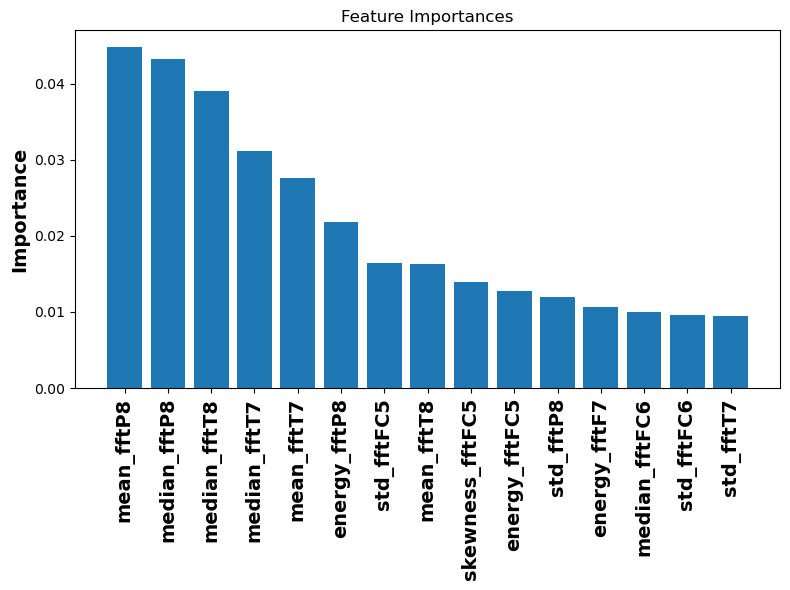

In [21]:
#Retrieve feature importance scores for RFC

feature_importances =  rfc_model.feature_importances_
normalized_importances = feature_importances / np.sum(feature_importances)


# Print the normalized feature importances
for feature_name, importance in zip(cols, feature_importances):
    print(f'{feature_name}: {importance}')
    
feature_names = cols
importances = normalized_importances
# print(importances)
indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.bar(range(15), sorted_importances[0:15])
plt.xticks(range(15), sorted_feature_names[0:15], rotation='vertical',fontsize=14, fontweight='bold' )
plt.ylabel('Importance',fontsize=14, fontweight='bold')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()



In [78]:
print(len(merged_data))/128

422026


TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [80]:
len(merged_data)/128/60

54.95130208333333

In [81]:
54/1000


0.054

In [82]:
.054*60

3.2399999999999998